## Проект  "Прогнозирование стоимости домов по их характеристикам"
- Автор: Когочкин Руслан

### Цель проекта
Сократить временные затраты и повысить точность оценки стоимости домов при работе риелторов.

### Задачи проекта
- провести разведывательный анализ данных (EDA)
- обработать исходные данные и создать новые признаки
- визуализировать связи признаков и целевой переменной
- отобрать важные признаки для обучения
- выбрать метрику, обучить несколько моделей и протестировать результаты
- выполнить стекинг лучших моделей
- сделать выводы и выбрать лучшую модель
- разработать прототип системы

### Импорт библиотек

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import json
from sklearn.model_selection import train_test_split, KFold, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR, LinearSVR
from scipy.stats import uniform, randint
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
import pickle
from sklearn.ensemble import StackingRegressor

### EDA и предобработка данных

In [2]:
df = pd.read_csv('data/data.csv')

In [3]:
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


Перед нами задача обучения с учителем, т.к. у нас помеченные обучающие образцы. Целевой переменной является цена дома. Также это задача многомерной регрессии, т.к. нужно предсказать непрерывное числовое значение по нескольким признакам.

In [4]:
print('Количество строк:', df.shape[0])
print('Количество колонок:', df.shape[1])

Количество строк: 377185
Количество колонок: 18


Удалим одинаковые строки.

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377135 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337218 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342402 non-null  object
 3   street        377133 non-null  object
 4   baths         270827 non-null  object
 5   homeFacts     377135 non-null  object
 6   fireplace     103112 non-null  object
 7   city          377101 non-null  object
 8   schools       377135 non-null  object
 9   sqft          336585 non-null  object
 10  zipcode       377135 non-null  object
 11  beds          285881 non-null  object
 12  state         377135 non-null  object
 13  stories       226462 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40310 non-null   object
 16  MlsId         310266 non-null  object
 17  target        374655 non-null  object
dtypes: object(18)
memory usa

Исходные данные (17 признаков, 1 целевая переменная):
- status - статус дома (на продажу, в аренду и т.п.)
- private pool - наличие личного бассейна
- propertyType - тип недвижимости (дом для одной семьи, кондоминиум, ...)
- street - улица, на которой расположен дом
- baths - количество ванных комнат в доме
- homeFacts - год постройки, год реконструкции, отопление, охлаждение, парковка, цена за кв. фут
- fireplace - наличие камина в доме
- city - название города, где расположен дом
- schools - информация о школах поблизости
- sqft - площадь дома в квадратных футах
- zipcode - почтовый индекс места, где расположен дом
- beds - количество спальных комнат в доме
- state - штат, в котором находится дом
- stories - количество этажей в доме
- mls-id - идентификатор агента по продаже недвижимости
- PrivatePool - наличие личного бассейна
- MlsId - идентификатор агента по продаже недвижимости
- target - стоимость дома в долларах США (целевая переменная)

Посмотрим на количество пропущенных значений.

In [7]:
df.isnull().sum()

status           39917
private pool    372954
propertyType     34733
street               2
baths           106308
homeFacts            0
fireplace       274023
city                34
schools              0
sqft             40550
zipcode              0
beds             91254
state                0
stories         150673
mls-id          352193
PrivatePool     336825
MlsId            66869
target            2480
dtype: int64

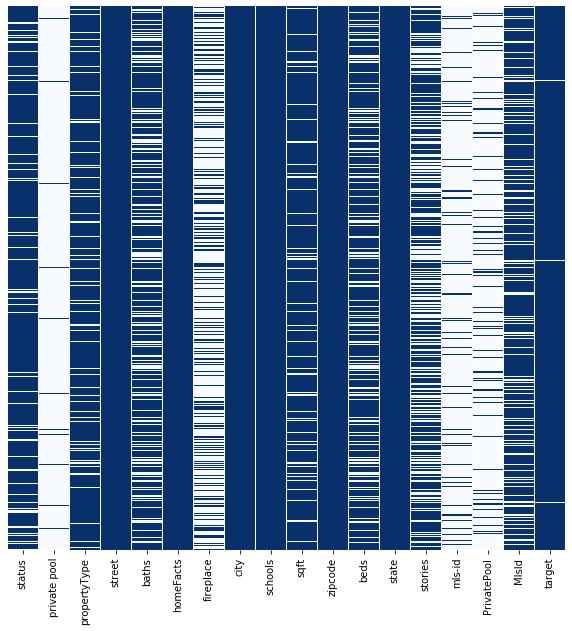

In [8]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='Blues_r');

Удалим строки, где одновременно пропущены признаки sqft, beds и baths.

In [9]:
df = df[~(df.baths.isnull() & df.sqft.isnull() & df.beds.isnull())]

Рассмотрим каждый признак по отдельности.

#### target (целевая переменная)

Цена дома имеет пропущенные значения. Удалим эти строки, т.к. будем использовать обучение с учителем.

In [10]:
df.dropna(subset=['target'], inplace=True)

Данные имеют тип object и содержат лишние символы '$', '+' и т.п. Преобразуем данные в тип int.

In [11]:
def target_to_int(value):
    value = value.replace('$', '').replace(',', '').replace('+', '').replace('/mo', '')
    if '-' in value:
        return int(value.split('-')[1])
    else:
        return int(value)

In [12]:
df['target'] = df['target'].apply(target_to_int)

Посмотрим на график распределения цен.

In [16]:
# настройки графика
sns.set_style("darkgrid")
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['figure.facecolor'] = '#00000000'

Minimum: 1
Maximum: 195000000
Average: 635261.0216643311


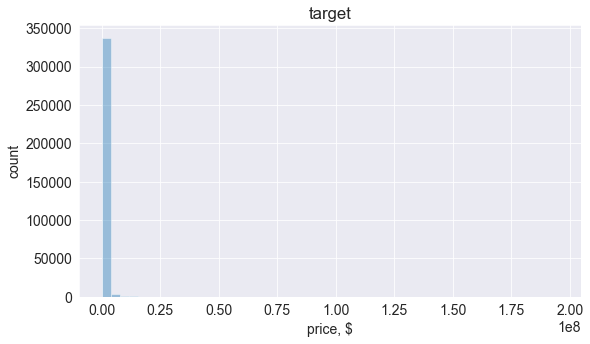

In [14]:
def print_distplot(title, xlabel, ylabel):
    plt.title(title)
    sns.distplot(df[title], kde=False);
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    print('Minimum:', df[title].min())
    print('Maximum:', df[title].max())
    print('Average:', df[title].mean())
    
print_distplot('target', 'price, $', 'count')

In [15]:
df['target'].describe()

count    3.432370e+05
mean     6.352610e+05
std      1.761071e+06
min      1.000000e+00
25%      1.999000e+05
50%      3.299000e+05
75%      5.849000e+05
max      1.950000e+08
Name: target, dtype: float64

Средняя цена (635261) сильно смещена вправо от медианы (329900) из-за наличия очень дорогих домов. Самый дорогой дом стоит $195 000 000 и находится в городе Los Angeles.

In [16]:
df[df['target'] == df['target'].max()]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
132425,For sale,NaN,Single Family,875 Nimes Rd,18.0,"{'atAGlanceFacts': [{'factValue': '1935', 'fac...",Yes,Los Angeles,"[{'rating': ['10/10', '7/10'], 'data': {'Dista...",--,90077,11,CA,2,NaN,Yes,18398466,195000000


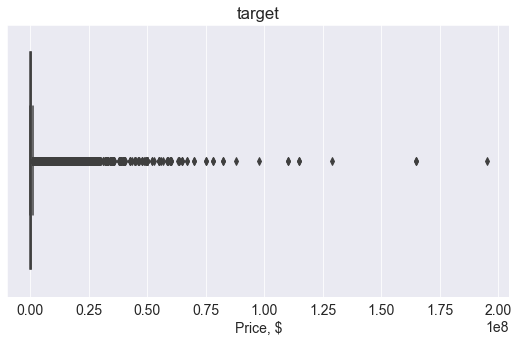

In [17]:
def print_boxplot(title, xlabel, null=0):
    if null == 0:
        x = df[title]
    else:
        x = df[title][~df[title].isnull()]
    plt.title(title)
    sns.boxplot(x=x);
    plt.xlabel(xlabel)
    
print_boxplot('target', 'Price, $')

Т.к. распределение имеет длинный правый хвост, то прологарифмируем целевую переменную.

In [18]:
df['target'] = np.log(df['target'] + 1)

Minimum: 0.6931471805599453
Maximum: 19.088510121656228
Average: 12.710051585081935


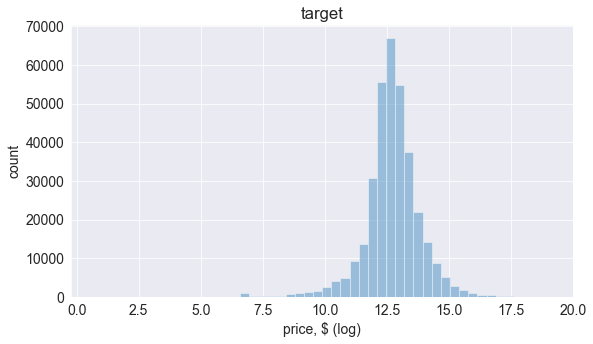

In [19]:
print_distplot('target', 'price, $ (log)', 'count')

Удалим часть предложений. Будем использовать межквартильный размах.

In [20]:
def get_boundaries(feature, value):
    IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    upper = df[feature].quantile(0.75) + value * IQR
    lower = df[feature].quantile(0.25) - value * IQR
    print('IQR =', IQR)
    print('upper =', upper)
    print('lower =', lower)
    return upper, lower
    
upper, lower = get_boundaries('target', 1.5)

IQR = 1.0736203581463908
upper = 14.889628418343207
lower = 10.595146985757644


Удалим строки, где цена больше верхней границы и меньше левой.

In [21]:
df = df[(df['target'] < upper) & (df['target'] > lower)]

In [22]:
df['target'].describe()

count    322372.000000
mean         12.752594
std           0.794047
min          10.595409
25%          12.264346
50%          12.712592
75%          13.244583
max          14.889147
Name: target, dtype: float64

Minimum: 10.595408982170255
Maximum: 14.889147202325647
Average: 12.752593751781927


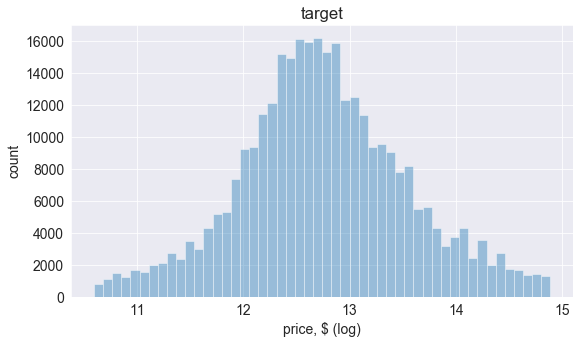

In [23]:
print_distplot('target', 'price, $ (log)', 'count')

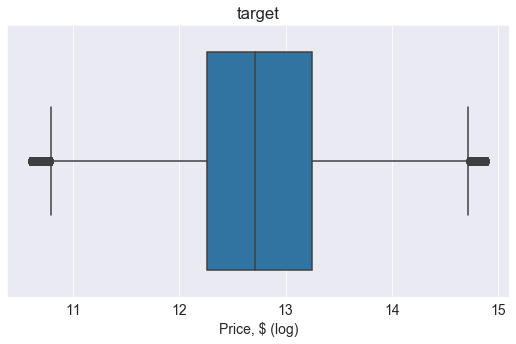

In [24]:
print_boxplot('target', 'Price, $ (log)')

#### Признак sqft
Признак обозначает площадь дома в квадратных футах.

In [25]:
def short_info(feature):
    '''Печатает краткую информацию по признаку feature'''
    null = df[feature].isnull().sum()
    proc = '(' + str(round(null * 100 / len(df), 1)) + '%)'
    print('Количество уникальных значений:', df[feature].nunique())
    print(f'Пропущенные значения в {feature}:', null, proc)

short_info('sqft')

Количество уникальных значений: 22828
Пропущенные значения в sqft: 7521 (2.3%)


In [26]:
df['sqft'].value_counts()

0                                          6377
1,200 sqft                                  776
1,000 sqft                                  609
1,800 sqft                                  546
1,100 sqft                                  543
                                           ... 
7,956 sqft                                    1
188,540 sqft                                  1
6,995 sqft                                    1
5,247                                         1
Total interior livable area: 5,226 sqft       1
Name: sqft, Length: 22828, dtype: int64

In [27]:
def set_sqft(sqft):
    ''' Принимает строку, содержащую число.
        Возвращает число из строки.
    '''
    try:
        sqft = re.findall('(\d+)', sqft)
        if len(sqft) == 1:
            return int(sqft[0])
        elif len(sqft) > 1:
            return int(sqft[0] + '' + sqft[1])
        return None
    except:
        return None
    
set_sqft('56,323 sqft ')

56323

In [28]:
df['sqft'] = df['sqft'].apply(set_sqft)

In [29]:
df['sqft'].describe()

count    3.141580e+05
mean     4.130673e+03
std      8.147457e+05
min      0.000000e+00
25%      1.265000e+03
50%      1.802000e+03
75%      2.548000e+03
max      4.566025e+08
Name: sqft, dtype: float64

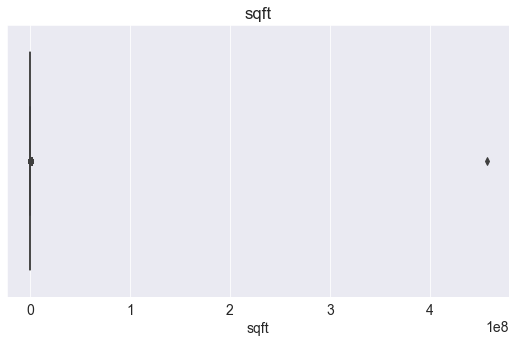

In [30]:
print_boxplot('sqft', 'sqft', null=1)

Удалим пропущенные значения.

In [31]:
df.dropna(subset=['sqft'], inplace=True)

Т.к. распределение имеет длинный правый хвост, то прологарифмируем признак.

In [32]:
df['sqft_log'] = np.log(df['sqft'] + 1)

Удалим выбросы, пользуясь верхней и нижней границами экстремальных значений.

In [33]:
upper, lower = get_boundaries('sqft_log', 1.5)

IQR = 0.6998388016719943
upper = 8.893214606884108
lower = 6.09385940019613


In [34]:
df = df[(df['sqft_log'] < upper) & (df['sqft_log'] > lower)]

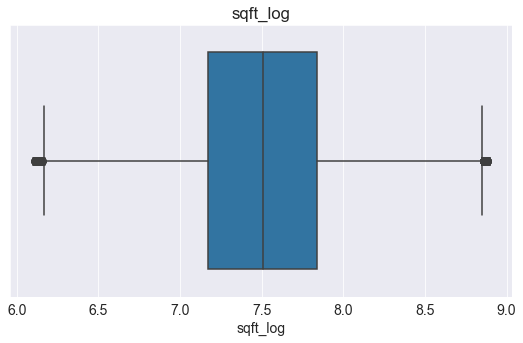

In [35]:
print_boxplot('sqft_log', 'sqft_log', null=1)

Minimum: 6.095824562432225
Maximum: 8.893023494394711
Average: 7.51030174572136


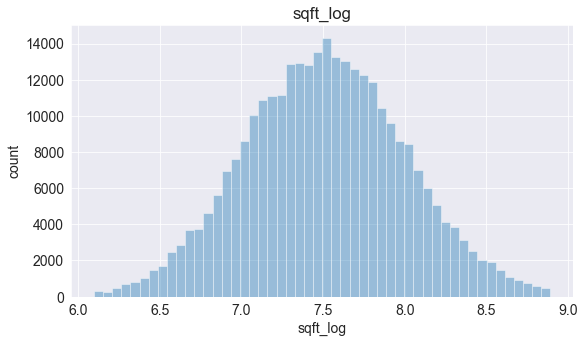

In [36]:
print_distplot('sqft_log', 'sqft_log', 'count')

#### Признак homeFacts

In [37]:
short_info('homeFacts')

Количество уникальных значений: 283007
Пропущенные значения в homeFacts: 0 (0.0%)


Посмотрим на данные.

In [38]:
df['homeFacts'].iloc[0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

In [39]:
df['homeFacts'].iloc[1]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '5828 sqft', 'factLabel': 'lotsize'}, {'factValue': '$159/sqft', 'factLabel': 'Price/sqft'}]}"

In [40]:
df['homeFacts'].iloc[2]

"{'atAGlanceFacts': [{'factValue': '1961', 'factLabel': 'Year built'}, {'factValue': '1967', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced Air', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': 'Attached Garage', 'factLabel': 'Parking'}, {'factValue': '8,626 sqft', 'factLabel': 'lotsize'}, {'factValue': '$965/sqft', 'factLabel': 'Price/sqft'}]}"

Интересным фактом является цена за квадратный фут 'Price/sqft'. Если ее умножить на площадь дома, то получим общую цену дома, т.е. наш target.

In [41]:
df['sqft'].iloc[0], np.exp(df['target'].iloc[0])

(2900.0, 418001.00000000023)

In [42]:
# площадь дома * цена за кв. фут
2900 * 144

417600

Сделаем следующие признаки: возраст дома, отопление, охлаждение, парковка, цена за кв. фут.

In [43]:
def set_facts(facts):
    try:
        facts = json.loads(facts.replace("'None'", '""').replace(", None", '') \
                           .replace("'None, ", '"').replace("None", '""') \
                           .replace("'", '"').replace('\"', '"') \
                           .replace('Attch"d', '').replace('Req"d', '') \
                           .replace('Addtn"l', '').replace('n"s', '') \
                           .replace('"closet"', ''))
    except:
        return (None, 0, 0, 0, None)
    try:
        age = 2020 - int(facts['atAGlanceFacts'][0]['factValue'])
        if age < 0:
            age = None
    except:
        age = 1
    heating = facts['atAGlanceFacts'][2]['factValue']
    if heating == '':
        heating = 0
    else:
        heating = 1
    cooling = facts['atAGlanceFacts'][3]['factValue']
    if cooling == '':
        cooling = 0
    else:
        cooling = 1
    parking = facts['atAGlanceFacts'][4]['factValue']
    if parking == '':
        parking = 0 
    else:
        parking = 1
    price_ft = re.findall('(\d+)', facts['atAGlanceFacts'][6]['factValue'])
    if len(price_ft) == 1:
        price_ft = int(price_ft[0])
    elif len(price_ft) > 1:
        price_ft = int(price_ft[0] + '' + price_ft[1])
    else:
        price_ft = None
    return age, heating, cooling, parking, price_ft

f = "{'atAGlanceFacts': [{'factValue': '1961', 'factLabel': 'Year built'}, {'factValue': '1967', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced Air', 'factLabel': 'Heating'}, {'factValue': None, 'factLabel': 'Cooling'}, {'factValue': 'Attached Garage', 'factLabel': 'Parking'}, {'factValue': '8,626 sqft', 'factLabel': 'lotsize'}, {'factValue': '$965/sqft', 'factLabel': 'Price/sqft'}]}"
set_facts(f)

(59, 1, 0, 1, 965)

In [44]:
df['homeFacts_new'] = df['homeFacts'].apply(set_facts)

In [45]:
df['age'] = df['homeFacts_new'].apply(lambda x: x[0])
df['heating'] = df['homeFacts_new'].apply(lambda x: x[1])
df['cooling'] = df['homeFacts_new'].apply(lambda x: x[2])
df['parking'] = df['homeFacts_new'].apply(lambda x: x[3])
df['price_ft'] = df['homeFacts_new'].apply(lambda x: x[4])

#### Признак age

In [46]:
short_info('age')

Количество уникальных значений: 217
Пропущенные значения в age: 54 (0.0%)


In [47]:
df['age'].describe()

count    303646.000000
mean         37.134706
std          33.175246
min           0.000000
25%           8.000000
50%          30.000000
75%          60.000000
max        1001.000000
Name: age, dtype: float64

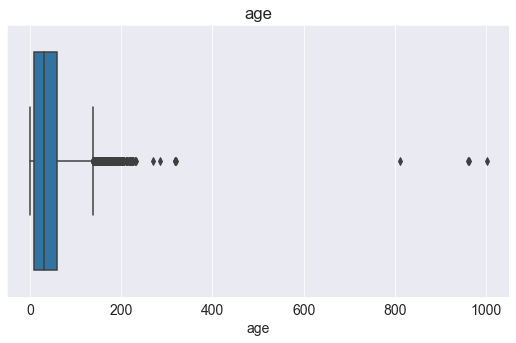

In [48]:
print_boxplot('age', 'age', null=1)

Удалим выбросы, пользуясь верхней и нижней границами экстремальных значений.

In [49]:
upper, lower = get_boundaries('age', 1.5)

IQR = 52.0
upper = 138.0
lower = -70.0


In [50]:
df.loc[df['age'] > upper, 'age'] = upper

Заменим пропущенные значения на средний возраст дома.

In [51]:
age_mean = round(df['age'].mean())
df['age'].fillna(age_mean, inplace=True)
print('Среднее значение:', age_mean)

Среднее значение: 37


Minimum: 0.0
Maximum: 138.0
Average: 37.06962133684557


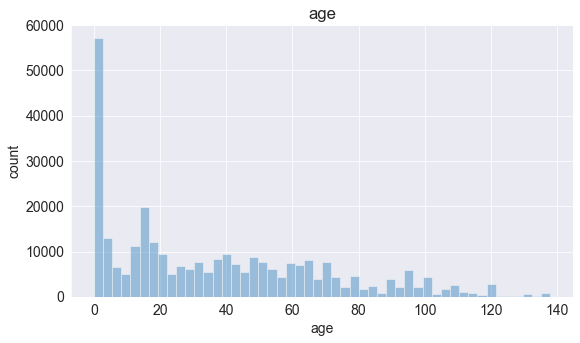

In [52]:
print_distplot('age', 'age', 'count')

#### Признаки heating, cooling, parking

In [53]:
df['heating'].value_counts()

1    243264
0     60436
Name: heating, dtype: int64

In [54]:
df['cooling'].value_counts()

1    229478
0     74222
Name: cooling, dtype: int64

In [55]:
df['parking'].value_counts()

1    184462
0    119238
Name: parking, dtype: int64

#### Признак price_ft

In [56]:
short_info('price_ft')

Количество уникальных значений: 1936
Пропущенные значения в price_ft: 11129 (3.7%)


In [57]:
df['price_ft'].describe()

count    292571.000000
mean        244.612016
std         208.462545
min           0.000000
25%         124.000000
50%         176.000000
75%         288.000000
max        5000.000000
Name: price_ft, dtype: float64

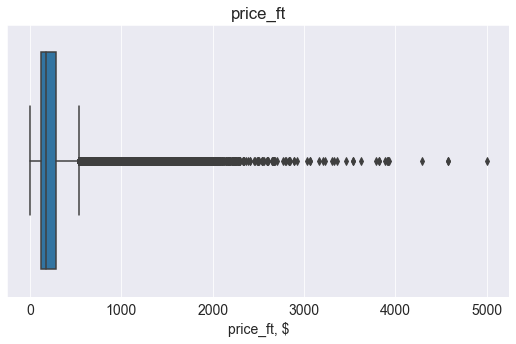

In [58]:
print_boxplot('price_ft', 'price_ft, $', null=1)

In [59]:
df.dropna(subset=['price_ft'], inplace=True)

Т.к. распределение имеет длинный правый хвост, то прологарифмируем признак.

In [60]:
df['price_ft'] = np.log(df['price_ft'] + 1)

Удалим выбросы, пользуясь верхней и нижней границами экстремальных значений.

In [61]:
upper, lower = get_boundaries('price_ft', 1.5)

IQR = 0.8381129508101308
upper = 6.923596114327628
lower = 3.5711443110871053


In [62]:
df = df[(df['price_ft'] < upper) & (df['price_ft'] > lower)]

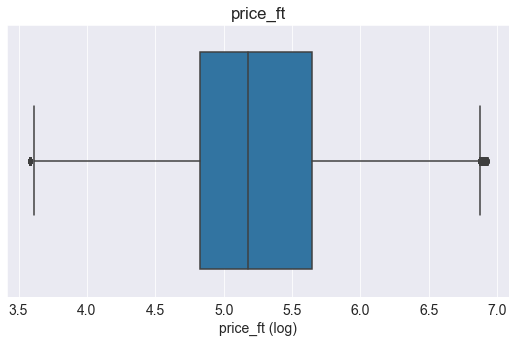

In [63]:
print_boxplot('price_ft', 'price_ft (log)', null=1)

Minimum: 3.58351893845611
Maximum: 6.922643891475888
Average: 5.255853602815548


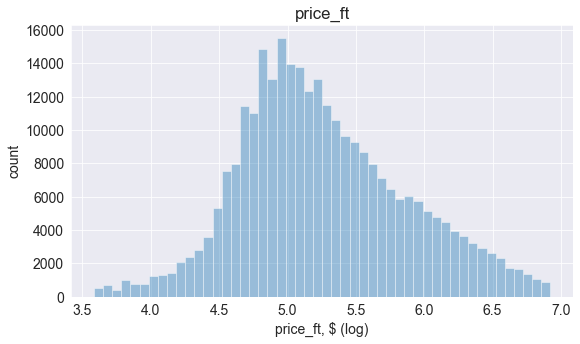

In [64]:
print_distplot('price_ft', 'price_ft, $ (log)', 'count')

In [65]:
# Удалим признаки homeFacts_new и homeFacts 
df.drop(['homeFacts_new', 'homeFacts'], axis=1, inplace=True)

#### Признак baths

In [66]:
short_info('baths')

Количество уникальных значений: 159
Пропущенные значения в baths: 52935 (18.4%)


In [67]:
df['baths'].value_counts()

2 Baths          48178
3 Baths          33469
2                19400
4 Baths          13506
2.0              12889
                 ...  
1-0 / 1-0 / 1        1
25 Baths             1
11 ba                1
1 / 1 / 1 / 1        1
5.25 Baths           1
Name: baths, Length: 159, dtype: int64

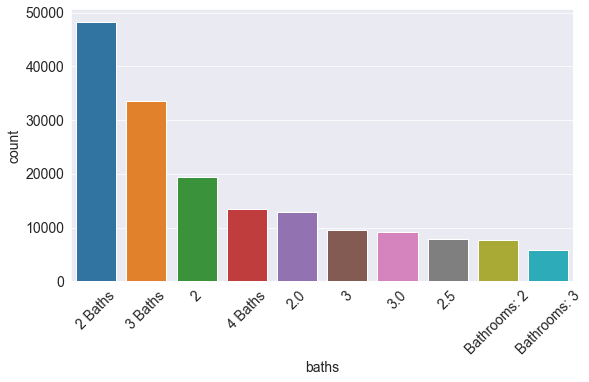

In [68]:
def print_countplot(x, count=2, rot=0):
    chart = sns.countplot(data=df, x=x, order=df[x].value_counts()[:count].index);
    chart.set_xticklabels(chart.get_xticklabels(), rotation=rot);
    
print_countplot('baths', count=10, rot=45)

Признак обозначает количество ванных комнат в доме. Напишем функцию, которая будет отбирать число из строки.

In [69]:
def set_baths(baths):
    ''' Принимает строку, содержащую число.
        Возвращает число из строки.
    '''
    if pd.isnull(baths):
        return None
    baths = re.findall('(\d+)', baths)
    if len(baths) == 1:
        return round(float(baths[0]))
    elif len(baths) > 1:
        return round(float(baths[0] + '.' + baths[1]))
    else:
        return None

In [70]:
df['baths_num'] = df['baths'].apply(set_baths)

В зависимости от площади дома соберем данные о медианном количестве ванных комнат. Заполним ими пропуски.

In [71]:
print('Количество ванных комнат в домах:')
print('- до 500 кв. ф.:', df['baths_num'][df['sqft'] < 500].median())
print('- от 500 до 2000 кв. ф.:', df['baths_num'][(df['sqft'] >= 500) & (df['sqft'] < 2000)].median())
print('- от 2000 до 3000 кв. ф.:', df['baths_num'][(df['sqft'] >= 2000) & (df['sqft'] < 3000)].median())
print('- от 3000 до 5000 кв. ф.:', df['baths_num'][(df['sqft'] >= 3000) & (df['sqft'] < 5000)].median())
print('- от 5000 до 6000 кв. ф.:', df['baths_num'][(df['sqft'] >= 5000) & (df['sqft'] < 6000)].median())
print('- от 6000 до 7000 кв. ф.:', df['baths_num'][(df['sqft'] >= 6000) & (df['sqft'] < 7000)].median())
print('- от 7000 до 8000 кв. ф.:', df['baths_num'][(df['sqft'] >= 7000) & (df['sqft'] < 8000)].median())

Количество ванных комнат в домах:
- до 500 кв. ф.: 1.0
- от 500 до 2000 кв. ф.: 2.0
- от 2000 до 3000 кв. ф.: 3.0
- от 3000 до 5000 кв. ф.: 4.0
- от 5000 до 6000 кв. ф.: 5.0
- от 6000 до 7000 кв. ф.: 6.0
- от 7000 до 8000 кв. ф.: 6.0


In [72]:
def fillna_baths(features):
    baths_num = features[0]
    sqft = features[1]
    if pd.isnull(baths_num) or baths_num == 0:
        if sqft < 500:
            return 1
        elif sqft >= 500 and sqft < 2000:
            return 2
        elif sqft >= 2000 and sqft < 3000:
            return 3
        elif sqft >= 3000 and sqft < 5000:
            return 4
        elif sqft >= 5000 and sqft < 6000:
            return 5
        else:
            return 6
    else:
        return baths_num

In [73]:
df['baths_num'] = df[['baths_num', 'sqft']].apply(fillna_baths, axis=1)

In [74]:
df['baths_num'].value_counts()[:10]

2.0      149562
3.0       72249
4.0       36524
1.0       14797
5.0        8544
6.0        3748
7.0         989
8.0         434
750.0       219
9.0          76
10.0         64
Name: baths_num, dtype: int64

In [75]:
df['baths_num'].describe()

count    287345.000000
mean          3.201935
std          20.656968
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max         750.000000
Name: baths_num, dtype: float64

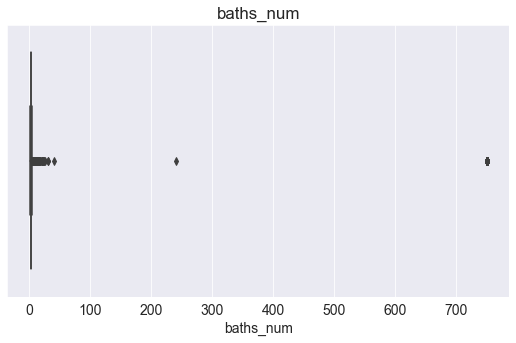

In [76]:
print_boxplot('baths_num', 'baths_num', null=1)

Оставим строки, где меньше 50 ванных комнат.

In [77]:
df = df[df['baths_num'] < 50]

Заменим выбросы значением верхней границы экстремальных значений.

In [78]:
upper, lower = get_boundaries('baths_num', 3)

IQR = 1.0
upper = 6.0
lower = -1.0


In [79]:
df.loc[df['baths_num'] > upper, 'baths_num'] = upper

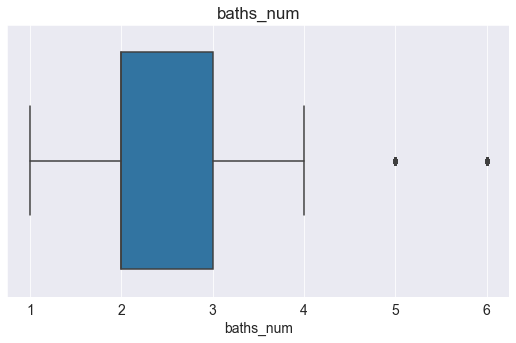

In [80]:
print_boxplot('baths_num', 'baths_num')

Minimum: 1.0
Maximum: 6.0
Average: 2.6196882890727036


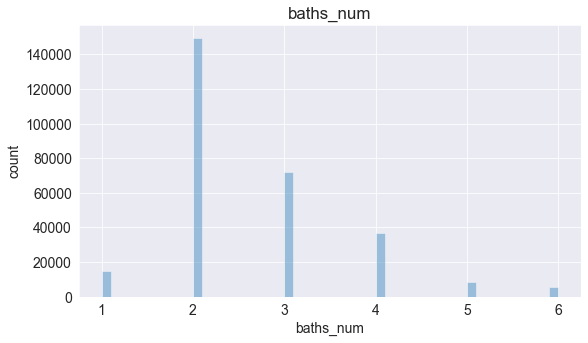

In [81]:
print_distplot('baths_num', 'baths_num', 'count')

In [82]:
# Удалим признак baths
df.drop(['baths'], axis=1, inplace=True)

#### Признак beds
Признак обозначает количество спальных комнат в доме.

In [83]:
short_info('beds')

Количество уникальных значений: 87
Пропущенные значения в beds: 43188 (15.0%)


In [84]:
df['beds'].value_counts()[:10]

3 Beds    48975
4 Beds    32839
3         27209
2 Beds    22855
4         17541
2         13882
Baths     12840
3 bd      10257
5 Beds     9659
3.0        7618
Name: beds, dtype: int64

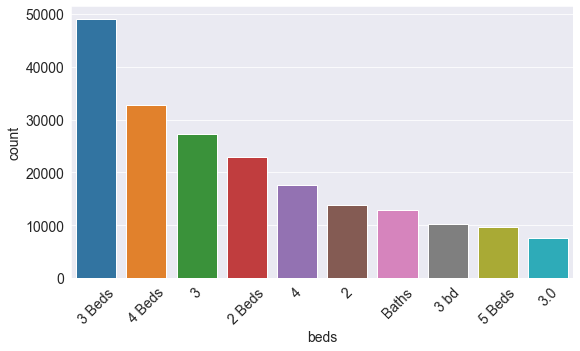

In [85]:
print_countplot('beds', count=10, rot=45)

In [86]:
def set_beds(value):
    if value == None:
        return None
    elif type(value) == str:
        value = value.lower()
        if 'acre' in value or 'sqft' in value or 'bath' in value:
            return None
        else:
            try:
                value = re.findall('(\d+)', value)
                if len(value) == 1:
                    return float(value[0])
                elif len(value) > 1:
                    return float(value[0] + '.' + value[1])
                return None
            except:
                return None
    return value
    
set_beds('50.0 beds')

50.0

In [87]:
df['beds_num'] = df['beds'].apply(set_beds)

В зависимости от площади дома соберем данные о медианном количестве спальных комнат.

In [88]:
print('Количество спальных комнат в домах:')
print('- до 500 кв. ф.:', df['beds_num'][df['sqft'] < 500].median())
print('- от 500 до 1000 кв. ф.:', df['beds_num'][(df['sqft'] >= 500) & (df['sqft'] < 1000)].median())
print('- от 1000 до 2000 кв. ф.:', df['beds_num'][(df['sqft'] >= 1000) & (df['sqft'] < 2000)].median())
print('- от 2000 до 3000 кв. ф.:', df['beds_num'][(df['sqft'] >= 2000) & (df['sqft'] < 3000)].median())
print('- от 3000 до 4000 кв. ф.:', df['beds_num'][(df['sqft'] >= 3000) & (df['sqft'] < 4000)].median())
print('- от 4000 до 5000 кв. ф.:', df['beds_num'][(df['sqft'] >= 4000) & (df['sqft'] < 5000)].median())
print('- от 5000 до 6000 кв. ф.:', df['beds_num'][(df['sqft'] >= 5000) & (df['sqft'] < 6000)].median())
print('- от 6000 до 7000 кв. ф.:', df['beds_num'][(df['sqft'] >= 6000) & (df['sqft'] < 7000)].median())
print('- от 7000 до 8000 кв. ф.:', df['beds_num'][(df['sqft'] >= 7000) & (df['sqft'] < 8000)].median())

Количество спальных комнат в домах:
- до 500 кв. ф.: 1.0
- от 500 до 1000 кв. ф.: 2.0
- от 1000 до 2000 кв. ф.: 3.0
- от 2000 до 3000 кв. ф.: 4.0
- от 3000 до 4000 кв. ф.: 4.0
- от 4000 до 5000 кв. ф.: 5.0
- от 5000 до 6000 кв. ф.: 5.0
- от 6000 до 7000 кв. ф.: 5.0
- от 7000 до 8000 кв. ф.: 5.0


In [89]:
def fillna_beds_num(features):
    beds_num = features[0]
    sqft = features[1]
    if pd.isnull(beds_num) or beds_num == 0:
        if sqft < 500:
            return 1
        elif sqft >= 500 and sqft < 1000:
            return 2
        elif sqft >= 1000 and sqft < 2000:
            return 3
        elif sqft >= 2000 and sqft < 4000:
            return 4
        else:
            return 5
    else:
        return beds_num

In [90]:
df['beds_num'] = df[['beds_num', 'sqft']].apply(fillna_beds_num, axis=1)

In [91]:
df['beds_num'].describe()

count    287125.000000
mean          3.300998
std           1.845693
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max         708.248000
Name: beds_num, dtype: float64

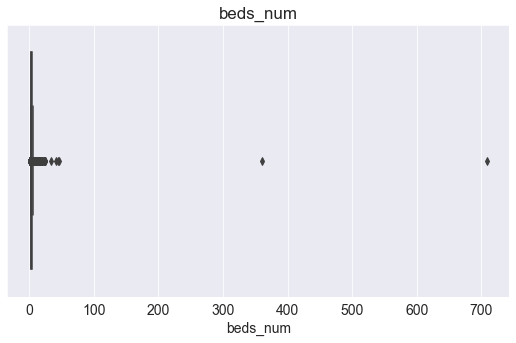

In [92]:
print_boxplot('beds_num', 'beds_num', null=1)

Оставим строки, где меньше 100 спальных комнат.

In [93]:
df = df[df['beds_num'] < 100]

Заменим выбросы значением верхней границы экстремальных значений.

In [94]:
upper, lower = get_boundaries('beds_num', 3)

IQR = 1.0
upper = 7.0
lower = 0.0


In [95]:
df.loc[df['beds_num'] > upper, 'beds_num'] = upper

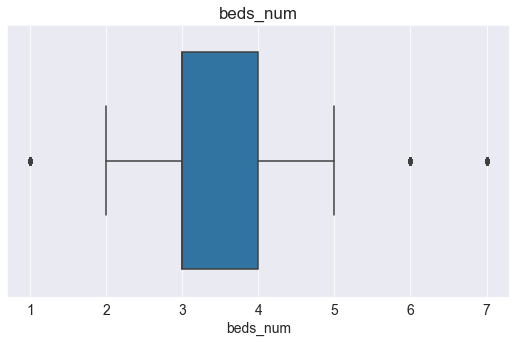

In [96]:
print_boxplot('beds_num', 'beds_num', null=1)

Minimum: 1.0
Maximum: 7.0
Average: 3.2835718489985126


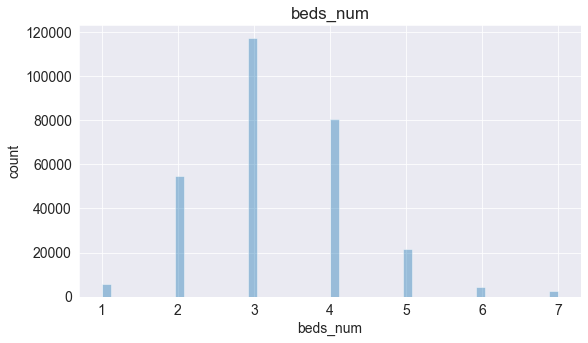

In [97]:
print_distplot('beds_num', 'beds_num', 'count')

In [98]:
# Удалим признак beds
df.drop(['beds'], axis=1, inplace=True)

#### Признак status

In [99]:
 short_info('status')

Количество уникальных значений: 140
Пропущенные значения в status: 28605 (10.0%)


Посмотрим на названия статусов.

In [100]:
status_list = df['status'].unique().tolist()
del status_list[2] # Удалим статус nan
status_list.sort()
print(status_list)

['A Active', 'Accepted Offer', 'Active', 'Active - Auction', 'Active - Contingent', 'Active Backup', 'Active Contingency', 'Active Contingent', 'Active Option', 'Active Option Contract', 'Active Under Contract', 'Active With Contingencies', 'Active With Offer', 'Active with Contract', 'Active/Contingent', 'Auction', 'Auction - Active', 'Back On Market', 'Back on Market', 'Backup Contract', 'C', 'C Continue Show', 'Closed', 'Coming soon: Dec 1.', 'Coming soon: Dec 10.', 'Coming soon: Dec 11.', 'Coming soon: Dec 12.', 'Coming soon: Dec 13.', 'Coming soon: Dec 14.', 'Coming soon: Dec 15.', 'Coming soon: Dec 16.', 'Coming soon: Dec 18.', 'Coming soon: Dec 2.', 'Coming soon: Dec 20.', 'Coming soon: Dec 23.', 'Coming soon: Dec 24.', 'Coming soon: Dec 25.', 'Coming soon: Dec 27.', 'Coming soon: Dec 3.', 'Coming soon: Dec 4.', 'Coming soon: Dec 5.', 'Coming soon: Dec 6.', 'Coming soon: Dec 7.', 'Coming soon: Dec 9.', 'Coming soon: Nov 11.', 'Coming soon: Nov 12.', 'Coming soon: Nov 13.', 'Comi

Некоторые названия повторяются, либо имеют разное написание. Преобразуем их, чтобы не было повторов.

In [101]:
def replace_feature(feature, to_replace, value):
    df[feature].replace(to_replace, value, inplace=True)

In [102]:
# auction
to_replace = [' / auction', 'Auction', 'Auction - Active']
replace_feature('status', to_replace, 'auction')
# active
to_replace = ['A Active', 'Active', 'Active - Auction', 'Active - Contingent', 'Active Backup',
    'Active Contingency', 'Active Contingent', 'Active Option', 'Active Option Contract',
    'Active Under Contract', 'Active With Contingencies', 'Active With Offer',
    'Active with Contract', 'Active/Contingent', 'Temporary Active']
replace_feature('status', to_replace, 'active')
# for rent
to_replace = ['Apartment for rent', 'Condo for rent']
replace_feature('status', to_replace, 'for rent')
# back on market
to_replace = ['Back On Market', 'Back on Market']
replace_feature('status', to_replace, 'back on market')
# backup
to_replace = ['Backup', 'Backup Contract', 'Accepting backups']
replace_feature('status', to_replace, 'backup')
# continue show
to_replace = ['C', 'C Continue Show']
replace_feature('status', to_replace, 'continue show')
# coming soon
to_replace = status_list[23:65]
replace_feature('status', to_replace, 'coming soon')
# contingent
to_replace = status_list[65:81]
replace_feature('status', to_replace, 'contingent')
# foreclosure
to_replace = ['Foreclosed', 'Foreclosure']
replace_feature('status', to_replace, 'foreclosure')
# for sale
to_replace = ['For Sale', 'For sale']
replace_feature('status', to_replace, 'for sale')
# new
to_replace = ['New', 'New construction']
replace_feature('status', to_replace, 'new')
# pending
to_replace = status_list[96:120]
replace_feature('status', to_replace, 'pending')
# pre-foreclosure
to_replace = ['Pre-foreclosure', 'Pre-foreclosure / auction']
replace_feature('status', to_replace, 'pre-foreclosure')
# under contract
to_replace = status_list[127:137]
replace_feature('status', to_replace, 'under contract')
# other
to_replace = ['Price Change', 'Option Pending', 'Option Contract', 'Contract P',
    'Pi', 'Listing Extended', 'Due Diligence Period',
    'Contract Contingent On Buyer Sale', 'Offer Pending Signature',
    'CT Insp - Inspection Contingency', 'Ct', 'Closed', 'Pf',
    'Accepted Offer', 'Lease/Purchase Pending', 'Ps', 'Re Activated',
    'Lease/Purchase', 'Conting Accpt Backups', 'Contract',
    'Reactivated', 'Conditional Contract', 'back on market',
    'coming soon', 'continue show', 'backup', 'contingent', 'auction', 'for rent']
replace_feature('status', to_replace, 'other')

Посмотрим на результат. Сделаем dummy-переменные из наиболее популярных статусов.

In [103]:
df['status'].value_counts()

for sale          163393
active             75417
pending             5815
new                 5365
foreclosure         3911
under contract      2711
other               1906
Name: status, dtype: int64

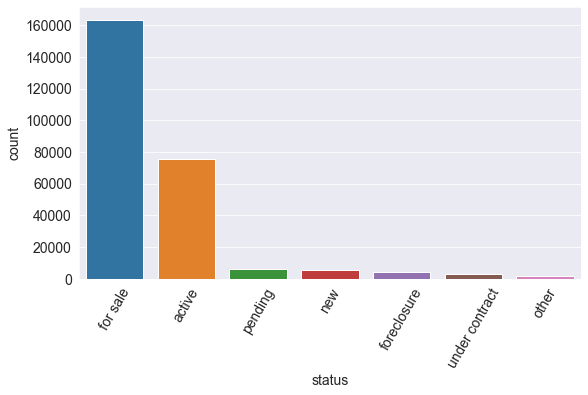

In [104]:
print_countplot('status', count=7, rot=60)

Самый часто встречаемый статус - "for sale". Колонка имеет пропущенные значения. Заполним их статусом "for sale".

In [105]:
df['status'].fillna('for sale', inplace=True)

Объединим датафрейм с dummy-переменными.

In [106]:
df = pd.concat([df, pd.get_dummies(df['status']).drop('other', axis=1)], axis=1)

In [107]:
# Удалим признак status
df.drop(['status'], axis=1, inplace=True)

#### Признак propertyType  

In [108]:
short_info('propertyType')

Количество уникальных значений: 1183
Пропущенные значения в propertyType: 15099 (5.3%)


In [109]:
df['propertyType'].value_counts()

single-family home                                             84092
Single Family                                                  50024
Single Family Home                                             29987
condo                                                          22075
Condo                                                          13745
                                                               ...  
1 Story, Spanish, Historic/Older                                   1
Farm House, Traditional, Transitional                              1
Single Detached, Contemporary/Modern, Oriental, Traditional        1
Farm/Ranch House, Contemporary/Modern                              1
Colonial, Federal                                                  1
Name: propertyType, Length: 1183, dtype: int64

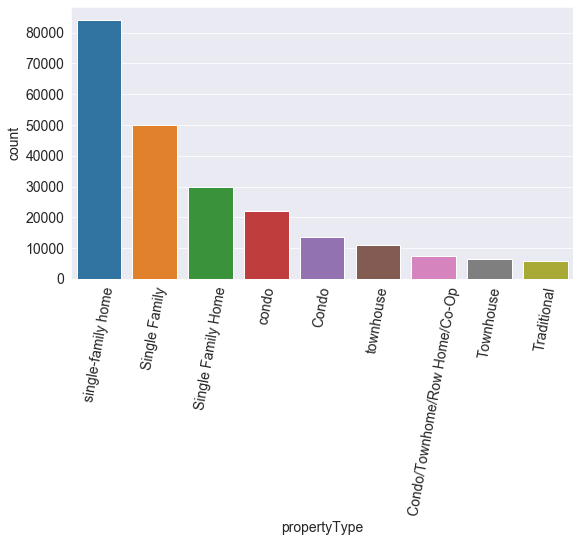

In [110]:
print_countplot('propertyType', count=9, rot=80)

Некоторые типы имеют составной вид и разделены запятыми. Исправим эту особенность.

In [111]:
property_types = pd.Series(df['propertyType'].unique())
property_types = property_types[~property_types.isnull()]

In [112]:
property_types_set = set()
for element in property_types:
    types = element.split(',')
    for i in types:
        property_types_set.add(i.strip())

In [113]:
print(property_types_set)

{'', 'Hi Ranch', 'High Rise', 'Mobile Home', 'Mediterranean', 'Attached', 'Carriage House', 'Farms/Ranches', '2-Story', 'Duplex', 'French', 'French Provincial', 'Santa Barbara/Tuscan', '2.5 Story', 'Art Deco', 'Mid-Rise (4-7 Stories)', 'Less Than 4 Floors', 'Country English', 'Manufactured Single-Wide', 'Coastal', 'One Level Unit', 'Rehab Needed', 'Saltbox', 'Dwelling w/Separate Living Area', 'Step Ranch', 'Queen Anne', 'Coastal Modern', 'Bermuda', 'Townhouse', 'High-Rise (8+ Stories)', 'Coastal Two Story', 'Transitional', 'Fourplex', 'Fairway house', 'Multi-Family Home', 'Other (See Remarks)', 'Single Family Home', 'AirLite', 'CRAFTSMAN', 'Side by Side', 'Custom Home', 'Condominium (3+ Levels)', 'Condo/Unit', 'Dome', 'Reproduction', 'Early American', 'Bungalow', 'Coastal Beach Home', 'Cottage', 'Spanish Colonial', 'Farm/Ranch House', 'Multiplex', 'Back-to-Back', 'Contemporary', 'Oriental', 'Single Wide MH', 'Walk-Out Ranch', 'Rancher', 'Townhouse-Interior', 'Colonial', '2 Stories', 'C

In [114]:
len(property_types_set)

275

Самый часто встречаемый тип - "single-family home". Колонка имеет пропущенные значения. Заполним их типом "single-family home".

In [115]:
df['propertyType'].fillna('single-family home', inplace=True)

Напишем функцию, которая будет заполнять новую колонку (dummy-переменную) для каждого уникального типа. Например, если встречается слово 'Coastal' в propertyType, то создать колонку 'Coastal' и т.п.

In [116]:
def set_property_type(propertyType, search_list):
    '''Проверяет, есть ли в строке propertyType
       хотя бы один из элементов списка search_list.
       Возвращает 1, если есть совпадение. Иначе 0.
    '''
    for element in search_list:
        if element in propertyType:
            return 1
    return 0

In [117]:
# single
search_list = ['Single Detached', 'Single Family', 'Single Family Home',
    'Single Wide', 'Single Wide MH', 'Single-Wide Mobile With Land',
    'SingleFamilyResidence','single-family home']
df['single'] = df['propertyType'].apply(set_property_type, search_list=search_list)
# 1_story
search_list = ['1 Story', '1 Story Traditional', '1 Story with Basement',
    '1 Story/Ranch', '1 story', 'One Story', '1 1/2 Story', '1 1/2 Story with Basement']
df['1_story'] = df['propertyType'].apply(set_property_type, search_list=search_list)
# 2_stories
search_list = ['2 Stories', '2 Stories with Basement', '2 Story',
    '2 Unit Condo', '2 story condo', '2-Story', '2.5 Story', 'Two Story']
df['2_stories'] = df['propertyType'].apply(set_property_type, search_list=search_list)

# Detached
search_list = ['Single Detached', 'Detached']
df['Detached'] = df['propertyType'].apply(set_property_type, search_list=search_list)

# Cooperative
search_list = ['Cooperative', 'coop', 'Co-op']
df['Cooperative'] = df['propertyType'].apply(set_property_type, search_list=search_list)
# Colonial
search_list = ['Colonial']
df['Colonial'] = df['propertyType'].apply(set_property_type, search_list=search_list)
# Condo
search_list = ['Condo', 'condo', 'Condo/Townhome', 'Condo/Townhome/Row Home/Co-Op',
    'Condo/Unit', 'Condominium', 'Condominium (2 Levels)', 'Condominium (3+ Levels)',
    'Condominium (Single Level)']
df['Condo'] = df['propertyType'].apply(set_property_type, search_list=search_list)
# Contemporary
search_list = ['Contemporary', 'Contemporary/Modern', 'Mountain Contemporary',
    'Northwestern Contemporary','Urban Contemporary', 'Modern',
    'Modern Architecture', 'Modernist']
df['Contemporary'] = df['propertyType'].apply(set_property_type, search_list=search_list)

# Ranch
search_list = ['Expanded Ranch', 'Farm House', 'Farm/Ranch', 'Farm/Ranch House',
    'Farmhouse', 'Farmhouse/National Folk', 'Farms/Ranches', 'Hi Ranch', 'High Ranch',
    'Raised Ranch', 'Ranch', 'Rancher', 'Step Ranch', 'Walk-Out Ranch',
    'Modern Farmhouse']
df['Ranch'] = df['propertyType'].apply(set_property_type, search_list=search_list)

# Hi-Rise
search_list = ['Hi-Rise', 'High Rise', 'High-Rise', 'High-Rise (8+ Stories)']
df['Hi-Rise'] = df['propertyType'].apply(set_property_type, search_list=search_list)

# Land
search_list = ['Land', 'lot/land']
df['Land'] = df['propertyType'].apply(set_property_type, search_list=search_list)

# mobile
search_list = ['Manuf/Mobile', 'Manufactured (Certificate Exchange)',
    'Manufactured Double-Wide', 'Manufactured Home', 'Manufactured Home - Double Wide',
    'Manufactured Home - Single Wide', 'Manufactured House',
    'Manufactured Single-Wide','Mfd/Mobile Home','Mobile / Manufactured',
    'Mobile Home', 'Mobile Home 1 Story', 'Mobile Manu - Double Wide','mobile/manufactured']
df['mobile'] = df['propertyType'].apply(set_property_type, search_list=search_list)

# multi-family
search_list = ['multi-family','Multi Family', 'Multi Generational',
    'Multi-Family', 'Multi-Family Home', 'Multiple Occupancy', 'Multiplex']
df['multi-family'] = df['propertyType'].apply(set_property_type, search_list=search_list)

# Townhouse
search_list = [ 'Townhome Style', 'Townhouse', 'Townhouse-End Unit',
    'Townhouse-Interior', 'townhouse']
df['Townhouse'] = df['propertyType'].apply(set_property_type, search_list=search_list)
# Traditional
search_list = ['Traditional']
df['Traditional'] = df['propertyType'].apply(set_property_type, search_list=search_list)

In [118]:
# Удалим признак propertyType
df.drop(['propertyType'], axis=1, inplace=True)

Посмотрим на количество новых признаков.

In [119]:
for property_type in df.columns[27:]:
    print(property_type, ':', df[property_type].sum())

single : 182257
1_story : 4203
2_stories : 2657
Detached : 5336
Cooperative : 1967
Colonial : 1119
Condo : 44182
Contemporary : 4494
Ranch : 2937
Hi-Rise : 1686
Land : 2170
mobile : 2659
multi-family : 8870
Townhouse : 17456
Traditional : 9370


#### Признак stories
Признак обозначает количество этажей в доме.

In [120]:
short_info('stories')

Количество уникальных значений: 299
Пропущенные значения в stories: 88076 (30.7%)


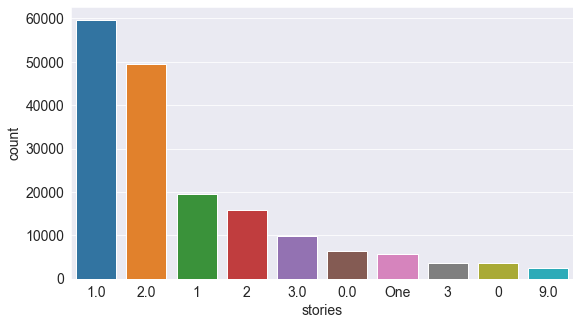

In [121]:
print_countplot('stories', count=10)

In [122]:
def set_story(value):
    ''' Принимает строку, содержащую число.
        Возвращает число из строки.
    '''
    if value == None:
        return None
    try:
        value = value.lower()
        result = re.findall('(\d+)', value)
        if len(result) > 0:
            return int(result[0])
        elif 'lot' in value:
            return 0
        elif 'one' in value:
            return 1
        elif 'two' in value or 'bi' in value:
            return 2
        elif 'three' in value or 'tri' in value:
            return 3
        elif 'four' in value:
            return 4
        elif 'five' in value:
            return 5           
        return None
    except:
        return None

In [123]:
df['story'] = df['stories'].apply(set_story)

В зависимости от площади дома соберем данные о медианном количестве этажей.

In [124]:
print('Количество этажей в домах:')
print('- до 500 кв. ф.:', df['story'][df['sqft'] < 500].median())
print('- от 500 до 1000 кв. ф.:', df['story'][(df['sqft'] >= 500) & (df['sqft'] < 1000)].median())
print('- от 1000 до 2000 кв. ф.:', df['story'][(df['sqft'] >= 1000) & (df['sqft'] < 2000)].median())
print('- от 2000 до 3000 кв. ф.:', df['story'][(df['sqft'] >= 2000) & (df['sqft'] < 3000)].median())
print('- от 3000 до 4000 кв. ф.:', df['story'][(df['sqft'] >= 3000) & (df['sqft'] < 4000)].median())
print('- от 4000 до 5000 кв. ф.:', df['story'][(df['sqft'] >= 4000) & (df['sqft'] < 5000)].median())
print('- от 5000 до 6000 кв. ф.:', df['story'][(df['sqft'] >= 5000) & (df['sqft'] < 6000)].median())
print('- от 6000 до 7000 кв. ф.:', df['story'][(df['sqft'] >= 6000) & (df['sqft'] < 7000)].median())
print('- от 7000 до 8000 кв. ф.:', df['story'][(df['sqft'] >= 7000) & (df['sqft'] < 8000)].median())

Количество этажей в домах:
- до 500 кв. ф.: 1.0
- от 500 до 1000 кв. ф.: 1.0
- от 1000 до 2000 кв. ф.: 1.0
- от 2000 до 3000 кв. ф.: 2.0
- от 3000 до 4000 кв. ф.: 2.0
- от 4000 до 5000 кв. ф.: 2.0
- от 5000 до 6000 кв. ф.: 2.0
- от 6000 до 7000 кв. ф.: 2.0
- от 7000 до 8000 кв. ф.: 2.0


In [125]:
def fillna_story(features):
    story = features[0]
    sqft = features[1]
    if pd.isnull(story) or story == 0:
        if sqft < 2000:
            return 1
        else:
            return 2
    else:
        return story

У нас есть dummy-переменная 1_story, отвечающая за один этаж в доме. Заменим пропущенные значения в созданной переменной story на 1, если dummy-переменная 1_story равна 1. Сделаем также для 2 этажей.

In [126]:
df.loc[(df['1_story'] == 1) & (df['story'].isnull()), 'story'] = 1
df.loc[(df['2_stories'] == 1) & (df['story'].isnull()), 'story'] = 2

In [127]:
df['story'] = df[['story','sqft']].apply(fillna_story, axis=1)

In [128]:
df['story'].describe()

count    287123.000000
mean          1.704823
std           2.490754
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1002.000000
Name: story, dtype: float64

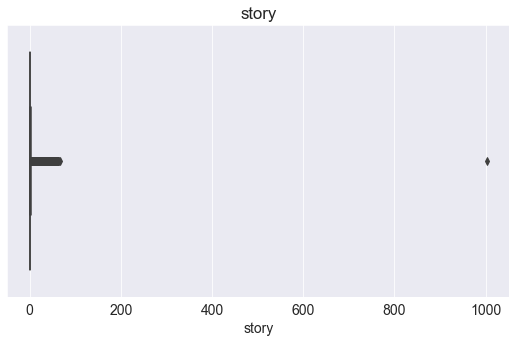

In [129]:
print_boxplot('story', 'story', null=1)

Оставим строки, где меньше 100 этажей.

In [130]:
df = df[df['story'] < 100]

Заменим выбросы значением верхней границы экстремальных значений.

In [131]:
upper, lower = get_boundaries('story', 3)

IQR = 1.0
upper = 5.0
lower = -2.0


In [132]:
df.loc[df['story'] > upper, 'story'] = upper

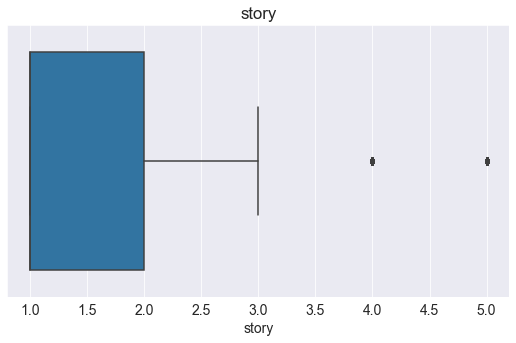

In [133]:
print_boxplot('story', 'story', null=1)

Minimum: 1.0
Maximum: 5.0
Average: 1.6026880559483425


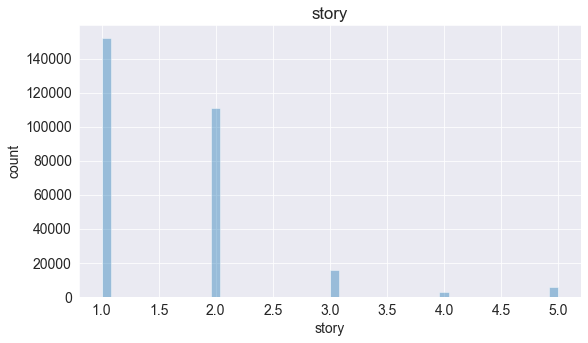

In [134]:
print_distplot('story', 'story', 'count')

In [135]:
# Удалим признак stories
df.drop(['stories'], axis=1, inplace=True)

#### Признак schools

In [136]:
short_info('schools')

Количество уникальных значений: 229185
Пропущенные значения в schools: 0 (0.0%)


Признак показывает информацию о ближайших школах: рейтинг, удаленность от дома, тип школы, название. Посмотрим на данные.

In [137]:
df.iloc[0].schools

'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

In [138]:
df.iloc[1].schools

"[{'rating': ['4/10', 'None/10', '4/10'], 'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'], 'Grades': ['9-12', '3-8', 'PK-8']}, 'name': ['East Valley High School&Extension', 'Eastvalley Middle School', 'Trentwood Elementary School']}]"

In [139]:
df.iloc[2].schools

"[{'rating': ['8/10', '4/10', '8/10'], 'data': {'Distance': ['1.19mi', '2.06mi', '2.63mi'], 'Grades': ['6-8', 'K-5', '9-12']}, 'name': ['Paul Revere Middle School', 'Brentwood Science School', 'Palisades Charter High School']}]"

In [140]:
df.iloc[100].schools

"[{'rating': ['3/10', '8/10', '5/10', '4/10', '5/10', '7/10', '5/10', '7/10', '7/10', '4/10', '3/10', '5/10', '7/10', '8/10', '5/10', '5/10', '7/10', '3/10', '4/10', '6/10', '6/10', '5/10', '6/10', '7/10'], 'data': {'Distance': ['7.66mi', '5.25mi', '5.19mi', '12.77mi', '6.92mi', '12.5mi', '4.33mi', '6.83mi', '2.16mi', '10.77mi', '8.84mi', '2.77mi', '3.68mi', '3.86mi', '8.47mi', '4.9mi', '9.68mi', '10.9mi', '8.41mi', '9.68mi', '5.59mi', '8.15mi', '3.88mi', '8.86mi'], 'Grades': ['PK-5', '6-8', 'PK-5', '9-12', '6-8', 'PK-8', '9-12', 'PK-5', 'PK-5', 'PK-5', 'PK-5', 'PK-5', '6-8', 'PK-5', '9-12', 'PK-5', 'PK-5', 'PK-5', 'PK-5', '6-8', 'PK-5', '6-8', '9-12', '9-12']}, 'name': ['Hector A. Cafferata Jr Elementary School', 'Challenger Middle School', 'Patriot Elementary School', 'Island Coast High School', 'Caloosa Middle School', 'North Fort Myers Academy For The Arts', 'Cape Coral High School', 'Caloosa Elementary School', 'Cape Elementary School', 'J. Colin English Elementary School', 'Tropi

Сделаем dummy-переменную, показывающую наличие школы с рейтингом от 8 и выше. А также посчитаем количество школ рядом с домом.

In [141]:
def set_schools(value):
    start_index = value.find(': [') + 2
    end_index = value.find(']') + 1
    value = value[start_index:end_index].replace("'", '"')
    value = json.loads(value)

    number = len(value)
    rating = 0
    for item in value:
        try:
            rating_value = int(item.split('/')[0])
            if rating_value >= 8:
                rating = 1
                break
        except:
            continue
        
    return number, rating

set_schools(df.iloc[0].schools)

(8, 0)

In [142]:
df['schools_new'] = df['schools'].apply(set_schools)
df['schools_num'] = df['schools_new'].apply(lambda x: x[0])
df['schools_8_up'] = df['schools_new'].apply(lambda x: x[1])

In [143]:
# Удалим признаки schools_new и schools
df.drop(['schools_new', 'schools'], axis=1, inplace=True)

#### Признак schools_num

In [144]:
df['schools_num'].describe()

count    287122.000000
mean          4.182476
std           4.381236
min           0.000000
25%           3.000000
50%           3.000000
75%           4.000000
max          65.000000
Name: schools_num, dtype: float64

Minimum: 0
Maximum: 65
Average: 4.182476438587082


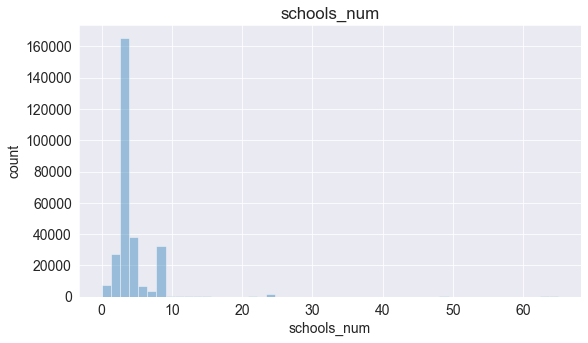

In [145]:
print_distplot('schools_num', 'schools_num', 'count')

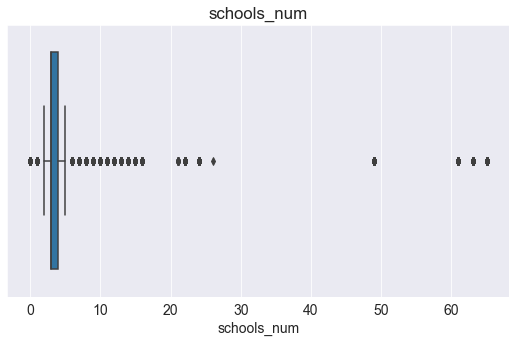

In [146]:
print_boxplot('schools_num', 'schools_num')

Заменим выбросы значением верхней границы экстремальных значений.

In [147]:
upper, lower = get_boundaries('schools_num', 3)

IQR = 1.0
upper = 7.0
lower = 0.0


In [148]:
df.loc[df['schools_num'] > upper, 'schools_num'] = upper

Minimum: 0.0
Maximum: 7.0
Average: 3.702694325060427


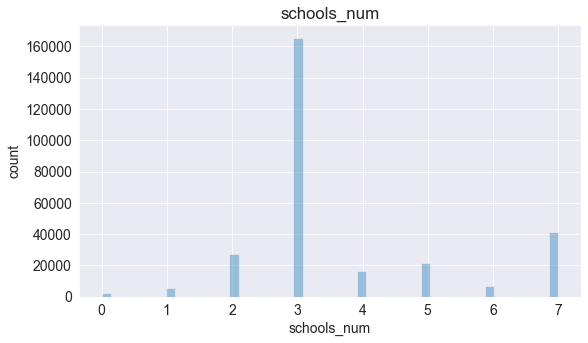

In [149]:
print_distplot('schools_num', 'schools_num', 'count')

#### Признак schools_8_up
Признак показывает наличие поблизости школы с рейтингом 8 и более.

In [150]:
df['schools_8_up'].value_counts()

0    174622
1    112500
Name: schools_8_up, dtype: int64

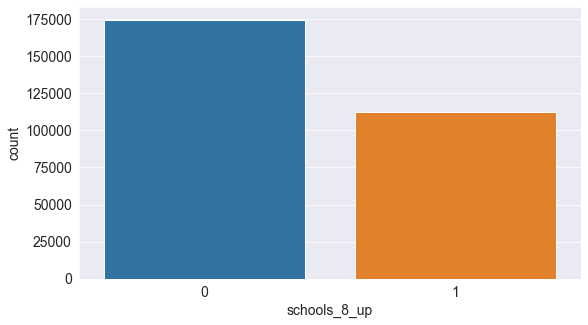

In [151]:
print_countplot('schools_8_up')

#### Признак fireplace

In [152]:
short_info('fireplace')

Количество уникальных значений: 1501
Пропущенные значения в fireplace: 195879 (68.2%)


In [153]:
df['fireplace'].value_counts()[:10]

yes               45221
Yes               16582
1                 13684
2                  2105
Not Applicable     1948
Fireplace           810
Living Room         390
3                   376
Wood Burning        300
Gas/Gas Logs        291
Name: fireplace, dtype: int64

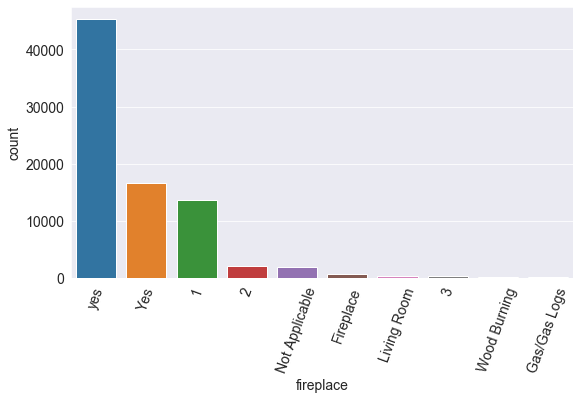

In [154]:
print_countplot('fireplace', count=10, rot=70)

Признак обозначает наличие камина в доме. Сделаем dummy-переменную. 1 - есть камин, 0 - нет. Заполним пропуски нулем.

In [155]:
df['fireplace'].fillna(0, inplace=True)

In [156]:
def set_fireplace(value):
    if value in [0, '0', 'Not Applicable', 'No']:
        return 0
    else:
        return 1
    
set_fireplace('No')

0

In [157]:
df['fireplace'] = df['fireplace'].apply(set_fireplace)

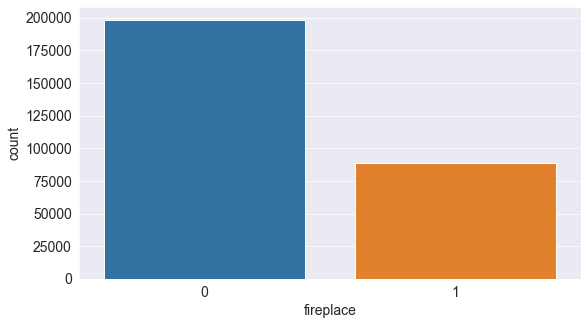

In [158]:
print_countplot('fireplace')

#### Признаки private pool и PrivatePool

Датасет имеет 2 признака, которые обозначают наличие/отсутствие бассейна. Оставим только один в виде dummy-переменной.

In [159]:
short_info('private pool')

Количество уникальных значений: 1
Пропущенные значения в private pool: 283673 (98.8%)


In [160]:
df['private pool'].unique().tolist()

[nan, 'Yes']

In [161]:
short_info('PrivatePool')

Количество уникальных значений: 2
Пропущенные значения в PrivatePool: 253265 (88.2%)


In [162]:
df['PrivatePool'].unique().tolist()

[nan, 'yes', 'Yes']

Т.к. в 'PrivatePool' меньше пропущенных значений, то оставим его. Значения nan преобразуем в 0. Это будет означать, что бассейна нет. А значения yes переведем в 1.

In [163]:
df['PrivatePool'].fillna(0, inplace=True)

In [164]:
to_replace = ['yes', 'Yes']
replace_feature('PrivatePool', to_replace, 1)

In [165]:
print(df['PrivatePool'].value_counts())

0    253265
1     33857
Name: PrivatePool, dtype: int64


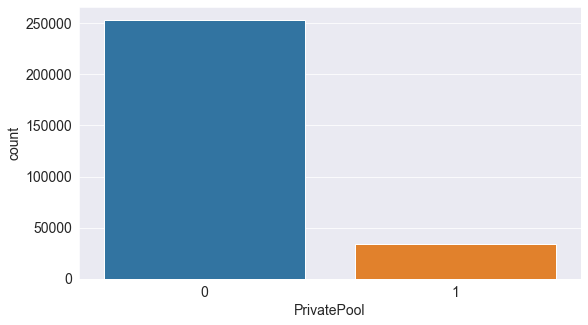

In [166]:
print_countplot('PrivatePool')

Удалим признак private pool из датасета.

In [167]:
df.drop(['private pool'], axis=1, inplace=True)

#### Прзнак state
Признак обозначает штат, где расположен дом.

In [168]:
short_info('state')

Количество уникальных значений: 36
Пропущенные значения в state: 0 (0.0%)


Посмотрим на названия штатов.

In [169]:
state_list = df['state'].unique().tolist()
state_list.sort()
print(state_list)

['AZ', 'CA', 'CO', 'DC', 'DE', 'FL', 'Fl', 'GA', 'IA', 'IL', 'IN', 'KY', 'MA', 'MD', 'ME', 'MI', 'MO', 'MS', 'MT', 'NC', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'OS', 'PA', 'SC', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI']


- Fl - это Флорида (FL)

Заменим неправильные названия штатов.

In [170]:
df['state'].replace(['Fl'], 'FL', inplace=True)

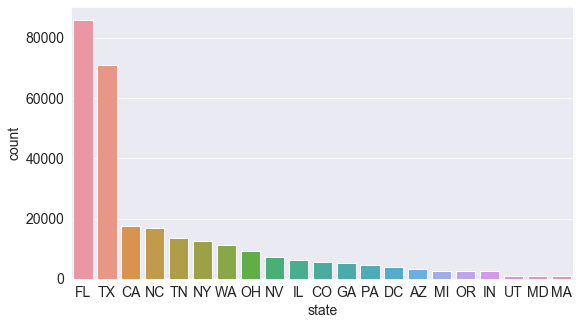

In [171]:
print_countplot('state', count=21)

Сделаем dummy-переменные из более распространенных штатов.

In [172]:
to_replace = df['state'].value_counts()[21:].index
replace_feature('state', to_replace, 'other')

Объединим датафрейм с dummy-переменными.

In [173]:
df = pd.concat([df, pd.get_dummies(df['state']).drop('other', axis=1)], axis=1)

In [174]:
# Удалим признак state
df.drop(['state'], axis=1, inplace=True)

#### Признак zipcode
Признак обозначает почтовый индекс.

In [175]:
short_info('zipcode')

Количество уникальных значений: 4304
Пропущенные значения в zipcode: 0 (0.0%)


In [176]:
df['zipcode'].value_counts()

33131         1405
78245         1333
34747         1295
78253         1207
78254         1206
              ... 
27617-7891       1
46819            1
76085            1
27609-6973       1
50431            1
Name: zipcode, Length: 4304, dtype: int64

Есть записи с лишними символами. Исправим это.

In [177]:
def set_zipcode(value):
    ''' Принимает строку, содержащую число.
        Возвращает число из строки.
    '''
    try:
        value = re.findall('(\d+)', value)
        if len(value) > 0:
            return int(value[0])
        return None
    except:
        return None
    
set_zipcode('27608-2709 ')

27608

In [178]:
df['zipcode'] = df['zipcode'].apply(set_zipcode)

In [179]:
df.dropna(subset=['zipcode'], inplace=True)

Minimum: 0.0
Maximum: 331446.0
Average: 53494.3631082366


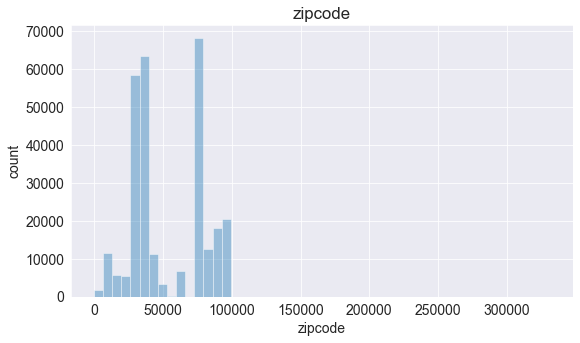

In [180]:
print_distplot('zipcode', 'zipcode', 'count')

В США почтовый индекс пятизначный, следовательно не может быть значений равных 0 и больше 99999. Если 3 или 4 цифры, то впереди стоят нули.

In [181]:
df = df[(df['zipcode'] > 0) & (df['zipcode'] < 100000)]

Minimum: 1103.0
Maximum: 99338.0
Average: 53493.133109498915


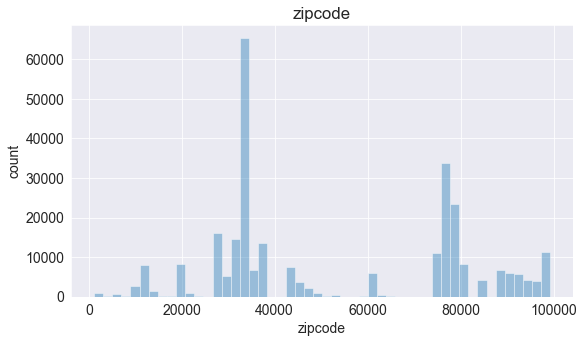

In [182]:
print_distplot('zipcode', 'zipcode', 'count')

Посмотрим на почтовые индексы, где средняя цена на жилье самая высокая.

In [183]:
df.groupby('zipcode')['target'].mean().sort_values(ascending=False).head(10)

zipcode
77546.0    14.827203
94123.0    14.807918
11249.0    14.690980
93108.0    14.667796
98039.0    14.665479
95030.0    14.648420
92067.0    14.624381
94707.0    14.603059
90291.0    14.588881
91108.0    14.577903
Name: target, dtype: float64

Оставим первые 800 самых "дорогих" индексов. Сделаем dummy-переменную, которая будет отвечать за "дороговизну". Если индекс попадает в список дорогих, то значение переменной 1.

In [184]:
zipcodes = df.groupby('zipcode')['target'].mean().sort_values(ascending=False).head(800).index

In [185]:
def set_zipcode(zipcode):
    if zipcode in zipcodes:
        return 1
    return 0

In [186]:
df['zipcode_expensive'] = df['zipcode'].apply(set_zipcode)

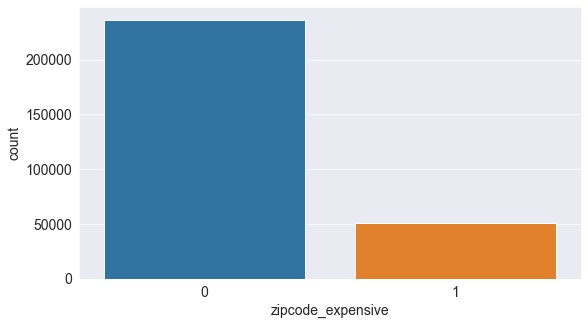

In [187]:
print_countplot('zipcode_expensive')

#### Признак city

In [188]:
short_info('city')

Количество уникальных значений: 1772
Пропущенные значения в city: 2 (0.0%)


Посмотрим на города, где средняя цена на жилье самая высокая.

In [189]:
df.groupby('city')['target'].mean().sort_values(ascending=False)[:10]

city
Friendswood           14.827203
Rancho Park           14.827112
Yarrow Point          14.767169
Clyde Hill            14.747530
BEND                  14.729800
CHERRYHILLSVILLAGE    14.669926
Jamaica Estates       14.669926
Medina                14.665479
Los Gatos             14.648420
Rancho Santa Fe       14.624381
Name: target, dtype: float64

Оставим первые 500 самых дорогих городов. Сделаем dummy-переменную, которая будет отвечать за "дороговизну" города. Если город попадает в список дорогих городов, то значение переменной 1.

In [190]:
cities = df.groupby('city')['target'].mean().sort_values(ascending=False)[:500].index

In [191]:
def set_city(city):
    if city in cities:
        return 1
    return 0

In [192]:
df['city_expensive'] = df['city'].apply(set_city)

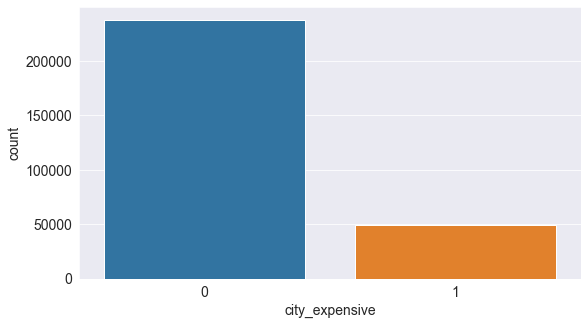

In [193]:
print_countplot('city_expensive')

In [194]:
# Удалим признак city
df.drop(['city'], axis=1, inplace=True)

#### Признак street

In [195]:
short_info('street')

Количество уникальных значений: 254062
Пропущенные значения в street: 1 (0.0%)


In [196]:
df['street'].value_counts()

Address Not Disclosed               481
Undisclosed Address                 378
(undisclosed Address)               318
Address Not Available               124
Unknown Address                      59
                                   ... 
6557 S Robb Way                       1
439 Turtleback Rdg                    1
400 S La Fayette Park Pl Apt 117      1
1221 Missouri St # 3                  1
5353 Gulf Blvd APT A402               1
Name: street, Length: 254062, dtype: int64

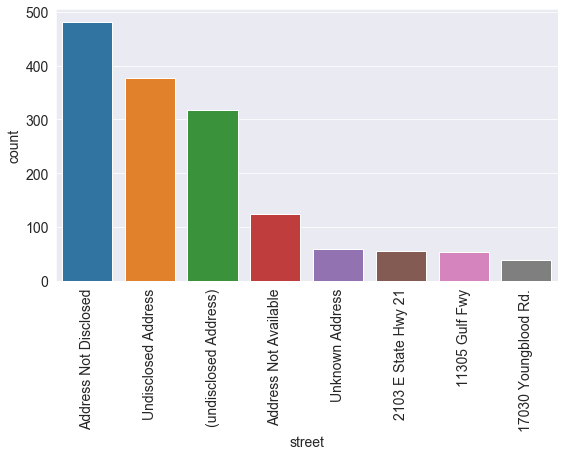

In [197]:
print_countplot('street', count=8, rot=90)

Признак обозначает улицу, где расположен дом. Слишком много уникальных значений для создания dummy-переменных. Удалим этот признак.

In [198]:
df.drop(['street'], axis=1, inplace=True)

#### Признаки mls-id и MlsId
Признак содержит идентификатор агента по продаже недвижимости.

In [199]:
short_info('mls-id')

Количество уникальных значений: 22786
Пропущенные значения в mls-id: 264310 (92.1%)


Слишком много пропущенных значений.

In [200]:
short_info('MlsId')

Количество уникальных значений: 177329
Пропущенные значения в MlsId: 47716 (16.6%)


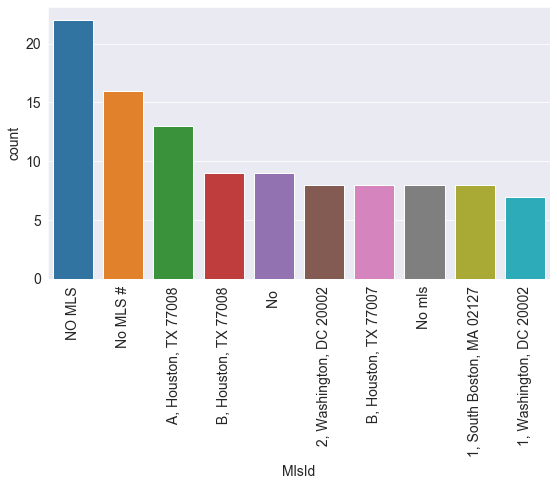

In [201]:
print_countplot('MlsId', count=10, rot=90)

Удалим эти признаки. Вряд ли они влияют на стоимость в данном случае.

In [202]:
df.drop(['MlsId', 'mls-id'], axis=1, inplace=True)

In [203]:
# Удалим признак sqft, т.к. у нас есть sqft_log
df.drop(['sqft'], axis=1, inplace=True)

Сохраним обработанный датасет в файл.

In [213]:
df.to_csv('data/data_ready.csv', index=False)

### Взаимодействия между признаками и целевой переменной

Определим, насколько каждый признак связан со стоимостью дома. Построим матрицу корреляций.

In [205]:
corr_matrix = df.corr()
corr_matrix = corr_matrix['target'].sort_values(ascending=False)

In [206]:
# Прямая корреляция
corr_1 = corr_matrix[:18].index
print(corr_matrix[:18])

target               1.000000
price_ft             0.759330
sqft_log             0.570383
baths_num            0.533524
zipcode_expensive    0.496820
city_expensive       0.420818
beds_num             0.378513
schools_8_up         0.270098
story                0.248936
CA                   0.215032
fireplace            0.148394
NY                   0.141725
PrivatePool          0.132526
multi-family         0.107666
WA                   0.106206
DC                   0.095162
parking              0.089119
zipcode              0.064333
Name: target, dtype: float64


In [207]:
# Обратная корреляция
corr_2 = corr_matrix[-10:].index
print(corr_matrix[-10:])

FL            -0.042023
PA            -0.054666
IN            -0.059507
heating       -0.064945
foreclosure   -0.077443
TX            -0.084862
MI            -0.103488
age           -0.104539
mobile        -0.134641
OH            -0.157640
Name: target, dtype: float64


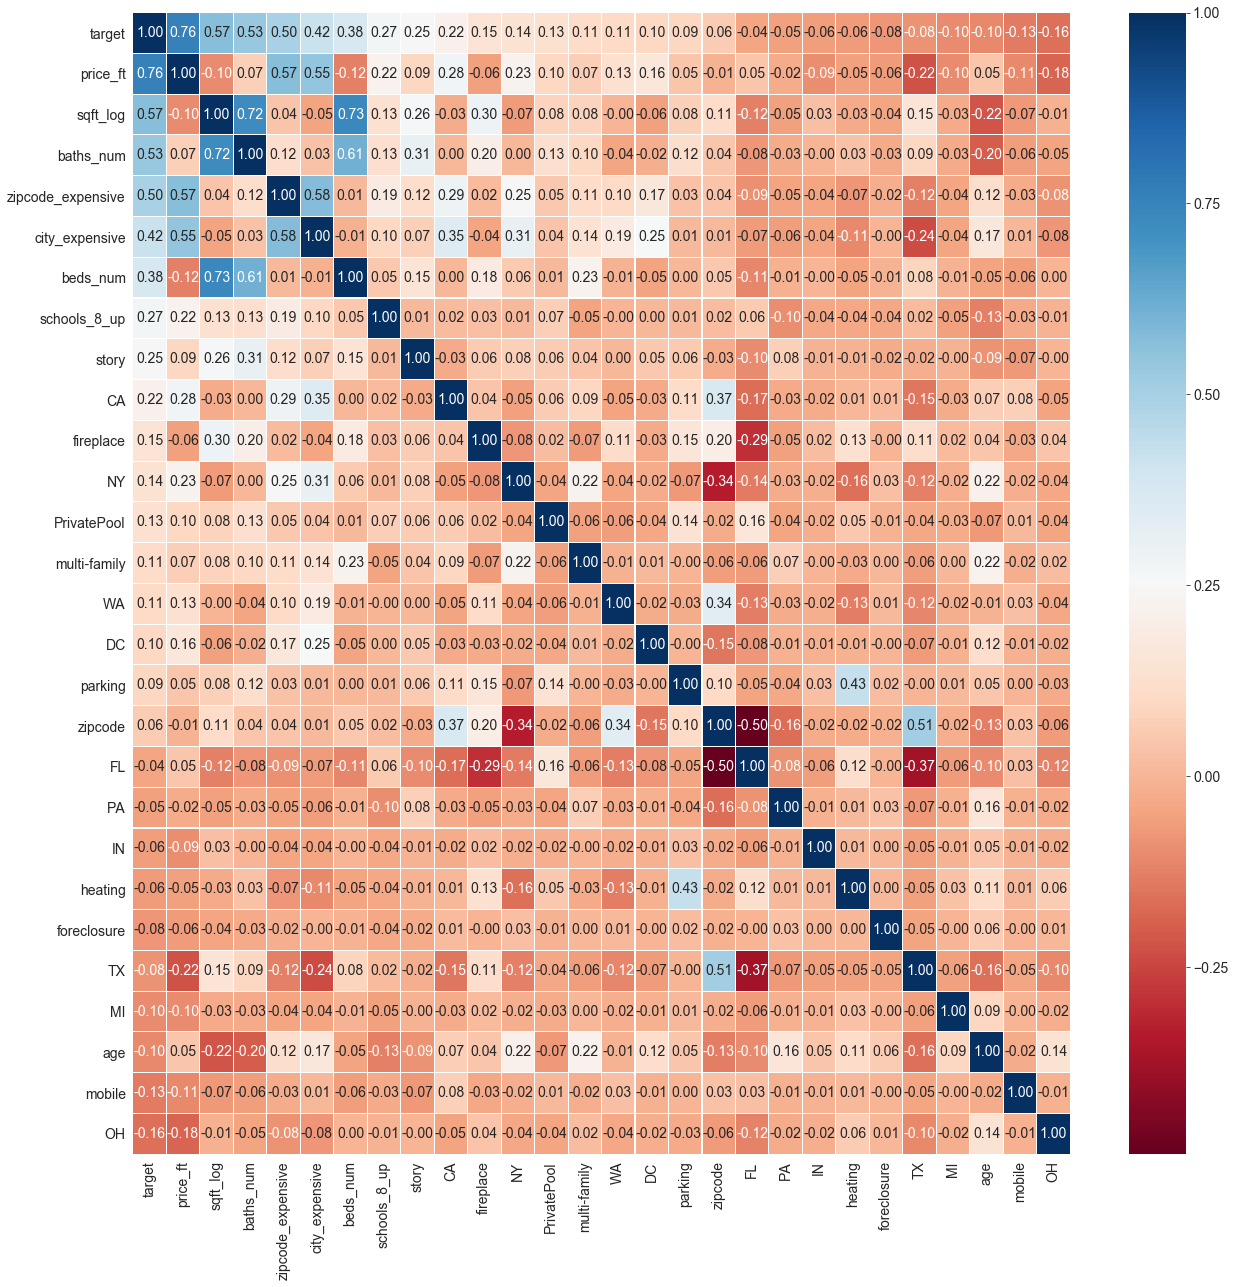

In [208]:
cor_features = corr_1.append(corr_2)
plt.figure(figsize=(21, 21))
sns.heatmap(df[cor_features].corr(), annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu");

Самая высокая прямая корреляция с ценой дома у следующих признаков: price_ft (цена за кв. фут), sqft_log (площадь дома), zipcode_expensive (дороговизна места), baths_num (количество ванных комнат). Присутствуют сильные взаимные корреляции между количеством ванных и общей площадью, а также между количеством спален и общей площадью. Имеется небольшая отрицательная корреляция цены дома с возрастом дома.

Построим график рассеяния корреляции цены с площадью, ценой за кв. фут, ванными и спальнями.

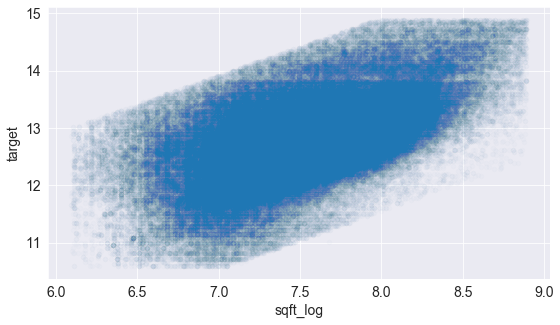

In [209]:
df.plot(kind='scatter', x='sqft_log', y='target', alpha=0.01);

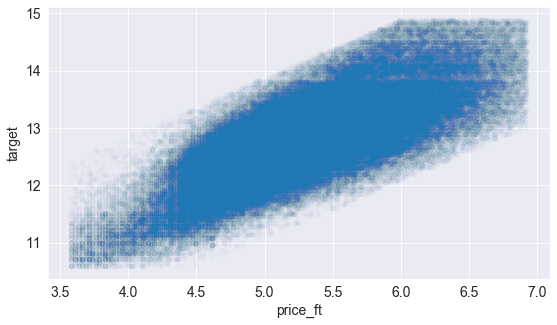

In [210]:
df.plot(kind='scatter', x='price_ft', y='target', alpha=0.01);

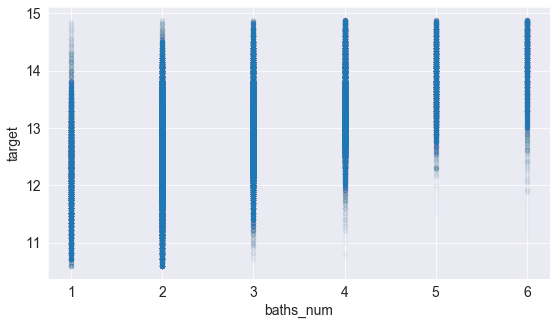

In [211]:
df.plot(kind='scatter', x='baths_num', y='target', alpha=0.01);

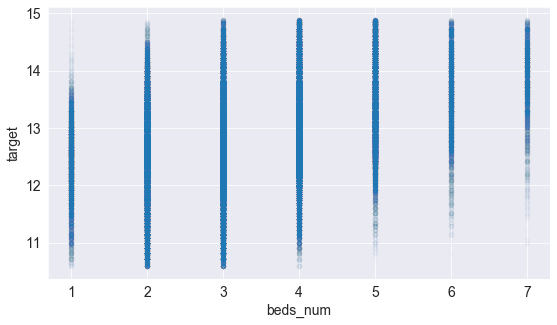

In [212]:
df.plot(kind='scatter', x='beds_num', y='target', alpha=0.01);

### Подготовка данных к обучению

Загрузим обработанный датасет.

In [3]:
df = pd.read_csv('data/data_ready.csv')

Выполним разделение датасета на тренировочный и тестовый наборы. Тестовый набор отложим и вернемся к нему в конце для итоговой оценки работы модели.

In [215]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

Применим стандартизацию к признакам.

In [216]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Обучение

В качестве метрики будем использовать MAPE - средняя абсолютная ошибка в процентах. Она позволяет просто интерпретировать результат на данных с сильным разбросом цен.

Попробуем сначала линейную модель Ridge.

In [217]:
linear_reg = Ridge()
linear_reg.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [218]:
y_pred = linear_reg.predict(X_test)

In [8]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))

def print_metrics(y_true, y_pred):
    '''Печатает RMSE, MAE, R2 и MAPE'''
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape_ = mape(y_true, y_pred)
    print(f'RMSE = {rmse:.2f}, MAE = {mae:.2f}, R-sq = {r2:.2f}, MAPE = {mape_:.3f}')

In [220]:
print_metrics(y_test, y_pred)

RMSE = 2809.63, MAE = 806.76, R-sq = 1.00, MAPE = 0.002


Сразу отличный результат? Ошибка MAPE 0%! Попробуем модель Random Forest.

In [221]:
forest_reg = RandomForestRegressor(n_estimators=10)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [222]:
y_pred = forest_reg.predict(X_test)
print_metrics(y_test, y_pred)

RMSE = 4710.16, MAE = 1537.60, R-sq = 1.00, MAPE = 0.003


Посмотрим на важность признаков.

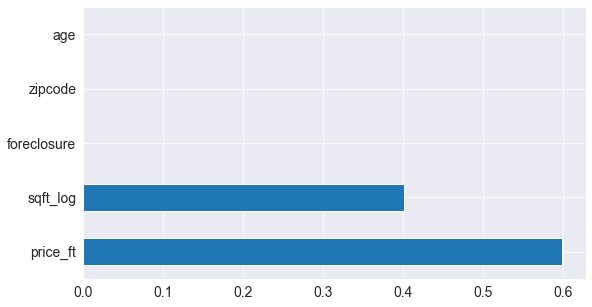

In [223]:
feat_importances = pd.Series(forest_reg.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh');

In [224]:
feat_importances.nlargest(10)

price_ft       0.598167
sqft_log       0.401669
foreclosure    0.000036
zipcode        0.000029
age            0.000021
beds_num       0.000011
IL             0.000009
schools_num    0.000007
baths_num      0.000004
heating        0.000003
dtype: float64

Ага! Модель использует только 2 признака: цену за кв. фут и площадь дома. Как было выявлено ранее, эта комбинация полностью объясняет целевую переменную.

Удалим признак price_ft, т.к. он, возможно, не должен был присутствовать в датасете. Также удалим признак city_expensive, т.к. по zipcode уже понятен город.

In [4]:
df.drop(['price_ft', 'city_expensive'], axis=1, inplace=True)

Заново выполним разделение и масштабирование.

In [5]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Посмотрим на результаты линейной регрессии теперь. Будем использовать перекрестную проверку на тренировочном наборе. В качестве метрики берем MAPE.

In [6]:
def cross_val(X, y, model, N_FOLDS, random_state):
    '''Выполняет перекрестную проверку
        и печатает данные по метрике'''
    score_ls = []
    cv = KFold(n_splits=N_FOLDS, random_state=random_state, shuffle=True)

    for idx, (train_index, test_index) in enumerate(cv.split(y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = model.fit(X_train, y_train)
        test_predict = model.predict(X_test)
        y_test = np.exp(y_test)
        test_predict = np.exp(test_predict)
        test_score = mape(y_test, test_predict)
        score_ls.append(test_score)
        print(f"{idx+1} Fold Val MAPE: {mape(y_test, test_predict):0.3f}")

    print(f'- Mean Score: {np.mean(score_ls):0.3f}')
    print(f'- Std Score: {np.std(score_ls):0.4f}')
    print(f'- Max Score: {np.max(score_ls):0.3f}')
    print(f'- Min Score: {np.min(score_ls):0.3f}')

#### Ridge

In [9]:
linear_reg = Ridge()
cross_val(X_train, y_train, model=linear_reg, N_FOLDS=4, random_state=5)

1 Fold Val MAPE: 0.348
2 Fold Val MAPE: 0.345
3 Fold Val MAPE: 0.346
4 Fold Val MAPE: 0.346
- Mean Score: 0.346
- Std Score: 0.0011
- Max Score: 0.348
- Min Score: 0.345


Среднее значение MAPE: 0.346.

Посмотрим результат на тесте.

In [10]:
linear_reg = Ridge()
linear_reg.fit(X_train, y_train)
y_pred_lin = linear_reg.predict(X_test)

In [11]:
print_metrics(y_test, y_pred_lin)

RMSE = 250713.26, MAE = 146748.42, R-sq = 0.64, MAPE = 0.345


#### Random Forest

In [12]:
forest_reg = RandomForestRegressor(n_estimators=10)
cross_val(X_train, y_train, model=forest_reg, N_FOLDS=4, random_state=5)

1 Fold Val MAPE: 0.207
2 Fold Val MAPE: 0.206
3 Fold Val MAPE: 0.208
4 Fold Val MAPE: 0.206
- Mean Score: 0.207
- Std Score: 0.0010
- Max Score: 0.208
- Min Score: 0.206


Результат лучше, чем у линейной модели. MAPE: 0.207.

In [13]:
forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [14]:
y_pred = forest_reg.predict(X_test)
print_metrics(y_test, y_pred)

RMSE = 168556.38, MAE = 83847.15, R-sq = 0.84, MAPE = 0.180


Посмотрим на важность признаков.

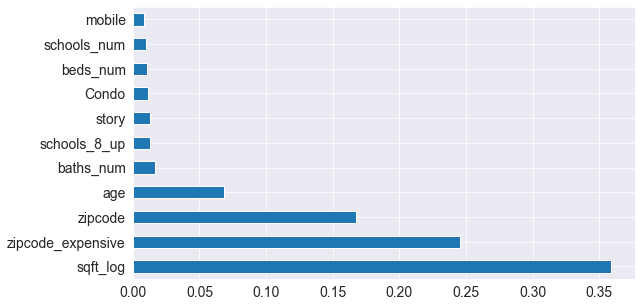

In [17]:
feat_importances = pd.Series(forest_reg.feature_importances_, index=X.columns)
feat_importances.nlargest(11).plot(kind='barh');

In [18]:
feat_importances.nlargest(15)

sqft_log             0.358820
zipcode_expensive    0.245513
zipcode              0.167603
age                  0.068401
baths_num            0.016579
schools_8_up         0.013186
story                0.012948
Condo                0.011330
beds_num             0.010495
schools_num          0.009870
mobile               0.008632
OH                   0.007164
cooling              0.005606
TX                   0.004932
fireplace            0.004620
dtype: float64

Возьмем 11 самых важных признаков для дальнейших экспериментов.

In [20]:
best_feature_names = list(feat_importances.nlargest(11).index)
print(best_feature_names)

['sqft_log', 'zipcode_expensive', 'zipcode', 'age', 'baths_num', 'schools_8_up', 'story', 'Condo', 'beds_num', 'schools_num', 'mobile']


In [21]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X.loc[:, best_feature_names], y, test_size=0.2, random_state=5)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Оптимизируем параметры модели.

In [239]:
def opt_model(model, param_grid):
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    print("Best Score: {}".format(grid_search.best_score_))
    print("Best params: {}".format(grid_search.best_params_))
    return grid_search.best_estimator_

In [240]:
forest_reg = RandomForestRegressor(n_estimators=10)
cross_val(X_train, y_train, model=forest_reg, N_FOLDS=4, random_state=5)

1 Fold Val MAPE: 0.193
2 Fold Val MAPE: 0.191
3 Fold Val MAPE: 0.192
4 Fold Val MAPE: 0.191
- Mean Score: 0.192
- Std Score: 0.0008
- Max Score: 0.193
- Min Score: 0.191


Обучим модель на всех тренировочных данных.

In [241]:
forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [242]:
y_pred = forest_reg.predict(X_test)
print_metrics(y_test, y_pred)

RMSE = 168685.87, MAE = 82242.77, R-sq = 0.84, MAPE = 0.177


Результат Random Forest на тестовой выборке: <b>MAPE = 0.177</b>

In [245]:
# Сохраним модель в файл:
with open('data/forest_reg.pkl', 'wb') as output:
    pickle.dump(forest_reg, output)

#### Gradient Boosting

In [248]:
grad_reg = GradientBoostingRegressor(n_estimators=100)
cross_val(X_train, y_train, model=grad_reg, N_FOLDS=4, random_state=5)

1 Fold Val MAPE: 0.311
2 Fold Val MAPE: 0.309
3 Fold Val MAPE: 0.311
4 Fold Val MAPE: 0.311
- Mean Score: 0.311
- Std Score: 0.0011
- Max Score: 0.311
- Min Score: 0.309


Результат Gradient Boosting на перекрестной проверке: MAPE = 0.311

In [253]:
grad_reg = GradientBoostingRegressor(n_estimators=100)
grad_reg.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [254]:
y_pred = grad_reg.predict(X_test)
print_metrics(y_test, y_pred)

RMSE = 236071.19, MAE = 134705.07, R-sq = 0.68, MAPE = 0.309


Результат Gradient Boosting на тестовой выборке: <b>MAPE = 0.309</b>

In [256]:
# Сохраним модель в файл:
with open('data/grad_reg.pkl', 'wb') as output:
    pickle.dump(grad_reg, output)

#### LightGBM

In [252]:
lgb_reg = lgb.LGBMRegressor(n_estimators=100)
cross_val(X_train, y_train, model=lgb_reg, N_FOLDS=4, random_state=5)

1 Fold Val MAPE: 0.269
2 Fold Val MAPE: 0.267
3 Fold Val MAPE: 0.268
4 Fold Val MAPE: 0.268
- Mean Score: 0.268
- Std Score: 0.0008
- Max Score: 0.269
- Min Score: 0.267


Результат LightGBM на перекрестной проверке: MAPE = 0.268

In [257]:
lgb_reg = lgb.LGBMRegressor(n_estimators=100)
lgb_reg.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [258]:
y_pred = lgb_reg.predict(X_test)
print_metrics(y_test, y_pred)

RMSE = 213484.92, MAE = 118648.29, R-sq = 0.74, MAPE = 0.266


Результат LightGBM на тестовой выборке: <b>MAPE = 0.266</b>

In [259]:
# Сохраним модель в файл:
with open('data/lgb_reg.pkl', 'wb') as output:
    pickle.dump(lgb_reg, output)

#### XGBoost

In [263]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=5)
cross_val(X_train, y_train, model=xgb_reg, N_FOLDS=4, random_state=5)

1 Fold Val MAPE: 0.228
2 Fold Val MAPE: 0.226
3 Fold Val MAPE: 0.227
4 Fold Val MAPE: 0.227
- Mean Score: 0.227
- Std Score: 0.0008
- Max Score: 0.228
- Min Score: 0.226


Результат XGBoost на перекрестной проверке: MAPE = 0.227

In [264]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=5)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=5, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [265]:
y_pred = xgb_reg.predict(X_test)
print_metrics(y_test, y_pred)

RMSE = 188367.10, MAE = 101489.26, R-sq = 0.80, MAPE = 0.224


Результат XGBoost на тестовой выборке: <b>MAPE = 0.224</b>

In [266]:
# Сохраним модель в файл:
with open('data/xgb_reg.pkl', 'wb') as output:
    pickle.dump(xgb_reg, output)

In [ ]:
xgb_model = xgb.XGBRegressor()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model,
                            param_distributions=params,
                            random_state=5,
                            n_iter=200, cv=3,
                            verbose=1,
                            n_jobs=-1,
                            return_train_score=True)

search.fit(X_train, y_train)

In [ ]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
report_best_scores(search.cv_results_, 1)

In [274]:
xgb_reg = xgb.XGBRegressor(**{'colsample_bytree': 0.9791316625975216,
                           'gamma': 0.09260358964106347,
                           'learning_rate': 0.3181154710162595,
                           'max_depth': 5,
                           'n_estimators': 148,
                           'subsample': 0.9690774894726759},
                           objective="reg:squarederror",
                           random_state=5)
cross_val(X_train, y_train, model=xgb_reg, N_FOLDS=4, random_state=5)

1 Fold Val MAPE: 0.230
2 Fold Val MAPE: 0.227
3 Fold Val MAPE: 0.229
4 Fold Val MAPE: 0.228
- Mean Score: 0.229
- Std Score: 0.0014
- Max Score: 0.230
- Min Score: 0.227


Нет улучшения после подбора параметров.

#### CatBoost

In [301]:
catboost = CatBoostRegressor(iterations = 2000,
                          learning_rate = 0.1,
                          random_seed = 5, 
                          eval_metric='MAPE',
                          verbose=False)
cross_val(X_train, y_train, model=catboost, N_FOLDS=4, random_state=5)

1 Fold Val MAPE: 0.234
2 Fold Val MAPE: 0.232
3 Fold Val MAPE: 0.233
4 Fold Val MAPE: 0.232
- Mean Score: 0.233
- Std Score: 0.0008
- Max Score: 0.234
- Min Score: 0.232


Результат CatBoost на перекрестной проверке: MAPE = 0.233

In [302]:
catboost = CatBoostRegressor(iterations = 4000,
                          learning_rate = 0.1,
                          random_seed = 5, 
                          eval_metric='MAPE',
                          verbose=False)
catboost.fit(X_train, y_train)

In [303]:
y_pred = catboost.predict(X_test)
print_metrics(y_test, y_pred)

RMSE = 184351.44, MAE = 98957.33, R-sq = 0.81, MAPE = 0.220


Результат CatBoost на тестовой выборке: <b>MAPE = 0.22</b>

In [304]:
# Сохраняем модель
catboost.save_model('data/catboost.model')

### Промежуточные выводы по обучению моделей
Результаты (метрика MAPE):
1. Random Forest - 0.177
2. CatBoost - 0.220
3. XGBoost - 0.224
4. LightGBM - 0.266
5. Gradient Boosting - 0.309

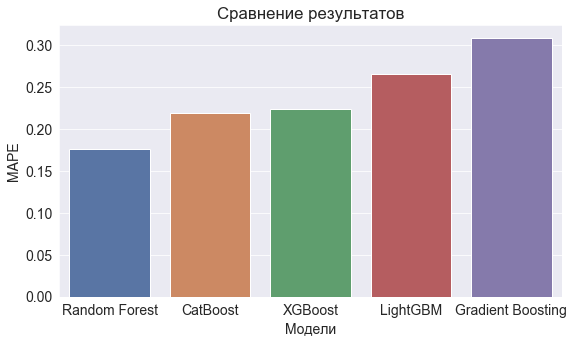

In [340]:
x = ['Random Forest', 'CatBoost', 'XGBoost', 'LightGBM', 'Gradient Boosting']
y = [0.177, 0.220, 0.224, 0.266, 0.309]

plt.title('Сравнение результатов')
sns.barplot(x=x, y=y, palette="deep");
plt.xlabel('Модели');
plt.ylabel('MAPE');

Лидер Random Forest, далее очень близко между собой CatBoost и XGBoost.

Попробуем сделать усреднение результатов 3 лучших моделей.

### Объединение предсказаний моделей и усреднение результата

Загрузим ранее обученные модели.

In [22]:
with open('data/forest_reg.pkl', 'rb') as pkl_file:
    forest_reg = pickle.load(pkl_file)

with open('data/xgb_reg.pkl', 'rb') as pkl_file:
    xgb_reg = pickle.load(pkl_file)
    
catboost = CatBoostRegressor()
catboost = catboost.load_model('data/catboost.model')

Сделаем предсказания для каждой модели.

In [330]:
forest_reg_predict = forest_reg.predict(X_test)
xgb_reg_predict = xgb_reg.predict(X_test)
catboost_predict = catboost.predict(X_test)

Усредним результаты.

In [331]:
y_pred = (forest_reg_predict + xgb_reg_predict + catboost_predict) / 3

In [332]:
print_metrics(y_test, y_pred)

RMSE = 173965.45, MAE = 90419.17, R-sq = 0.83, MAPE = 0.197


<b>MAPE = 0.197</b>. Результат усреднения не дотягивает до лучшего результата Random Forest! Попробуем стекинг моделей.

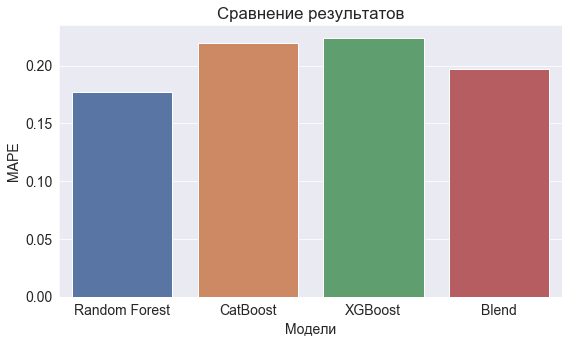

In [342]:
x = ['Random Forest', 'CatBoost', 'XGBoost', 'Blend']
y = [0.177,  0.220, 0.224, 0.197]

plt.title('Сравнение результатов')
sns.barplot(x=x, y=y, palette="deep");
plt.xlabel('Модели');
plt.ylabel('MAPE');

### Стекинг

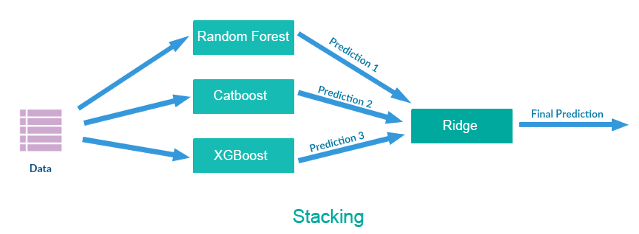

В качестве первого слоя будем использовать Random Forest, Catboost и XGBoost. Финальный слой - линейная регрессия Ridge.

In [27]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=5);
forest_reg = RandomForestRegressor(n_estimators=100);
catboost = CatBoostRegressor(iterations = 4000,
                          learning_rate = 0.1,
                          random_seed = 5, 
                          eval_metric='MAPE',
                          verbose=False);

In [30]:
layer1 = list()
layer1.append(('RF', forest_reg))
layer1.append(('XGB', xgb_reg))
layer1.append(('Cat', catboost))

layer2 = Ridge()

model = StackingRegressor(estimators=layer1, final_estimator=layer2, cv=3)

In [31]:
model.fit(X_train, y_train)

StackingRegressor(cv=3,
                  estimators=[('RF',
                               RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_e

In [32]:
y_pred = model.predict(X_test)
print_metrics(y_test, y_pred)

RMSE = 165645.82, MAE = 84285.32, R-sq = 0.84, MAPE = 0.182


<b>MAPE = 0.182</b>. Результат стекинга не дотягивает до лучшего результата Random Forest, но лучше усреднения.

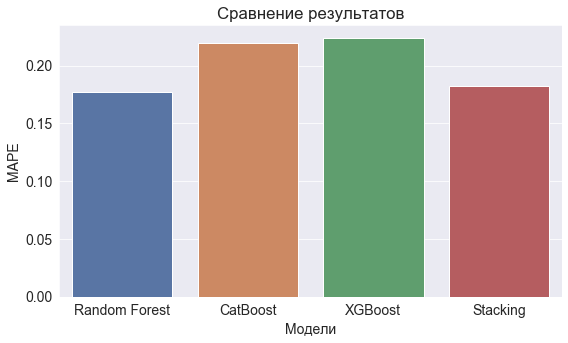

In [33]:
x = ['Random Forest', 'CatBoost', 'XGBoost', 'Stacking']
y = [0.177,  0.220, 0.224, 0.182]

plt.title('Сравнение результатов')
sns.barplot(x=x, y=y, palette="deep");
plt.xlabel('Модели');
plt.ylabel('MAPE');

In [34]:
# Сохраним модель в файл:
with open('data/stacking.pkl', 'wb') as output:
    pickle.dump(model, output)

Второй вариант стекинга.

In [42]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=5);
forest_reg = RandomForestRegressor(n_estimators=100);
catboost = CatBoostRegressor(iterations = 4000,
                          learning_rate = 0.1,
                          random_seed = 5, 
                          eval_metric='MAPE',
                          verbose=False);

In [43]:
layer1 = list()
layer1.append(('RF', forest_reg))
layer1.append(('XGB', xgb_reg))
layer1.append(('Cat', catboost))

layer2 = RandomForestRegressor(n_estimators=20)

model = StackingRegressor(estimators=layer1, final_estimator=layer2, cv=3)

In [44]:
model.fit(X_train, y_train)

StackingRegressor(cv=3,
                  estimators=[('RF',
                               RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_e

In [45]:
y_pred = model.predict(X_test)
print_metrics(y_test, y_pred)

RMSE = 175604.84, MAE = 92342.68, R-sq = 0.82, MAPE = 0.202


Результат хуже, чем в первом варианте.

Стекинг не смог улучшить результат лидера Random Forest!

### Выводы

1. В ходе этапа разведывательного анализа данных (EDA) был подробно рассмотрен каждый из 17 признаков. Выявлено, что перед нами задача обучения с учителем, т.к. у нас помеченные обучающие образцы. Целевой переменной является цена дома. Также это задача многомерной регрессии, т.к. нужно предсказать непрерывное числовое значение по нескольким признакам. Целевая переменная target была прологарифмирована, т.к. ее распределение имело длинный правый хвост. Для каждого признака произведена работа с выбросами (использовался межквартильный размах) и заполнением пропусков. После обработки данных количество признаков увеличилось до 58.


2. Визуализация показала высокую прямую корреляция с ценой дома у следующих признаков: price_ft (цена за кв. фут), sqft_log (площадь дома), zipcode_expensive (дороговизна места), baths_num (количество ванных комнат). Присутствуют сильные взаимные корреляции между количеством ванных и общей площадью, а также между количеством спален и общей площадью. Имеется небольшая отрицательная корреляция цены дома с возрастом дома.


3. С помощью модели Random Forest произведен отбор важных признаков. Их количество сократилось до 11: sqft_log, zipcode_expensive, zipcode, age, baths_num, schools_8_up, story, Condo, beds_num, schools_num, mobile. Площадь дома - это прогнозатор номер один цен на дома. Был удален признак "цена за кв. фут", т.к. он, возможно, не должен присутствовать в датасете.


4. В качестве метрики выбрана MAPE - средняя абсолютная ошибка в процентах. Она позволяет просто интерпретировать результат на данных с сильным разбросом цен. На этапе обучения были обучены 6 различных моделей: Ridge, Random Forest, Gradient Boosting, LightGBM, XGBoost, CatBoost. Результаты на тестовом наборе (метрика MAPE):
    - Random Forest - 0.177
    - CatBoost - 0.220
    - XGBoost - 0.224
    - LightGBM - 0.266
    - Gradient Boosting - 0.309
    - Ridge - 0.345


5. После усреднения результатов 3 лучших моделей показатель MAPE (0.197) не улучшил результат Random Forest. Стекинг 3 лучших моделей также не показал улучшения показателя Random Forest. Результат стекинга - 0.182. Таким образом, победила модель Random Forest с результатом MAPE 0.177. Т.е. модель может ошибаться в среднем на 17%.

Таким образом, обученную модель Random Forest можно применять на практике для сокращения временных затрат и повышения точности оценки стоимости домов при работе риелторов. Для повышения точности можно собрать дополнительные признаки. Например, медианный доход в округе, население округа, общее косметическое состояние дома.

### Список использованных источников и литературы

- Орельен Жерон, Прикладное машинное обучение с помощью Scikit-Learn и TensorFlow, 2018 г.
- сайт для риелторов США, http://www.mls.com/
- статья Stacking Ensemble Machine Learning With Python, https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/